In [1]:
%cd /global/cfs/cdirs/m4334/jerry/climsim3_dev

/global/cfs/cdirs/m4334/jerry/climsim3_dev


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import torch
import os, gc, sys, glob, string, argparse
import modulus
from tqdm import tqdm
import sys
from climsim_utils.data_utils import *

In [3]:
grid_path = '/global/cfs/cdirs/m4334/jerry/climsim3_dev/grid_info/ClimSim_low-res_grid-info.nc'

input_mean_v2_rh_mc_file = 'input_mean_v2_rh_mc_pervar.nc'
input_max_v2_rh_mc_file = 'input_max_v2_rh_mc_pervar.nc'
input_min_v2_rh_mc_file = 'input_min_v2_rh_mc_pervar.nc'
output_scale_v2_rh_mc_file = 'output_scale_std_lowerthred_v2_rh_mc.nc'

input_mean_v6_file = 'input_mean_v6_pervar.nc'
input_max_v6_file = 'input_max_v6_pervar.nc'
input_min_v6_file = 'input_min_v6_pervar.nc'
output_scale_v6_file = 'output_scale_std_lowerthred_v6.nc'

lbd_qn_file = 'qn_exp_lambda_large.txt'

grid_info = xr.open_dataset(grid_path)

input_mean_v2_rh_mc = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/' + input_mean_v2_rh_mc_file)
input_max_v2_rh_mc = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/' + input_max_v2_rh_mc_file)
input_min_v2_rh_mc = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/' + input_min_v2_rh_mc_file)
output_scale_v2_rh_mc = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/outputs/' + output_scale_v2_rh_mc_file)

input_mean_v6 = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/' + input_mean_v6_file)
input_max_v6 = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/' + input_max_v6_file)
input_min_v6 = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/' + input_min_v6_file)
output_scale_v6 = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/outputs/' + output_scale_v6_file)

lbd_qn = np.loadtxt('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/' + lbd_qn_file, delimiter = ',')

data_v2_rh_mc = data_utils(grid_info = grid_info, 
                           input_mean = input_mean_v2_rh_mc, 
                           input_max = input_max_v2_rh_mc, 
                           input_min = input_min_v2_rh_mc, 
                           output_scale = output_scale_v2_rh_mc,
                           qinput_log = False,
                           normalize = False)
data_v2_rh_mc.set_to_v2_rh_mc_vars()

data_v6 = data_utils(grid_info = grid_info,
                     input_mean = input_mean_v6,
                     input_max = input_max_v6,
                     input_min = input_min_v6,
                     output_scale = output_scale_v6,
                     qinput_log = False,
                     normalize = False)                     
data_v6.set_to_v6_vars()

actual_input_v2_rh_mc = np.load('/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/actual_input.npy')
actual_target_v2_rh_mc = np.load('/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/actual_target.npy')

actual_input_v6 = np.load('/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v6/test_set/actual_input.npy')
actual_target_v6 = np.load('/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v6/test_set/actual_target.npy')

assert np.array_equal(actual_target_v2_rh_mc, actual_target_v6)
actual_target = actual_target_v2_rh_mc
del actual_target_v2_rh_mc
del actual_target_v6

assert np.array_equal(actual_input_v2_rh_mc[:,:,data_v2_rh_mc.ps_index], 
                      actual_input_v6[:,:,data_v6.ps_index])

surface_pressure = actual_input_v2_rh_mc[:, :, data_v2_rh_mc.ps_index]
hyam_component = (data_v2_rh_mc.hyam * data_v2_rh_mc.p0)[None,None,:]
hybm_component = data_v2_rh_mc.hybm[None,None,:] * surface_pressure[:,:,None]
pressures = hyam_component + hybm_component
pressures_binned = data_v2_rh_mc.zonal_bin_weight_3d(pressures)
lat_bin_mids = data_v2_rh_mc.lat_bin_mids

In [4]:
standard_save_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/test_preds/standard/'
conf_loss_save_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/test_preds/conf_loss/'
diff_loss_save_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/test_preds/diff_loss/'
multirep_save_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/test_preds/multirep/'
v6_save_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v6/test_set/test_preds/'

def load_seed_data(save_path, npz_file, seed_key):
    with np.load(os.path.join(save_path, npz_file)) as data:
        return data[seed_key]

seeds = ['seed_7', 'seed_43', 'seed_1024']

print('loading standard preds')
standard_preds = {
    'unet': lambda seed_key: load_seed_data(standard_save_path, 'standard_unet_preds.npz', seed_key),
    'squeezeformer': lambda seed_key: load_seed_data(standard_save_path, 'standard_squeezeformer_preds.npz', seed_key),
    'pure_resLSTM': lambda seed_key: load_seed_data(standard_save_path, 'standard_pure_resLSTM_preds.npz', seed_key),
    'pao_model': lambda seed_key: load_seed_data(standard_save_path, 'standard_pao_model_preds.npz', seed_key),
    'convnext': lambda seed_key: load_seed_data(standard_save_path, 'standard_convnext_preds.npz', seed_key),
    'encdec_lstm': lambda seed_key: load_seed_data(standard_save_path, 'standard_encdec_lstm_preds.npz', seed_key)
}

print('loading conf loss preds')
conf_loss_preds = {
    'unet': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_unet_preds.npz', seed_key),
    'squeezeformer': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_squeezeformer_preds.npz', seed_key),
    'pure_resLSTM': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_pure_resLSTM_preds.npz', seed_key),
    'pao_model': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_pao_model_preds.npz', seed_key),
    'convnext': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_convnext_preds.npz', seed_key),
    'encdec_lstm': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_encdec_lstm_preds.npz', seed_key)
}

print('loading conf loss conf')
conf_loss_conf = {
    'unet': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_unet_conf.npz', seed_key),
    'squeezeformer': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_squeezeformer_conf.npz', seed_key),
    'pure_resLSTM': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_pure_resLSTM_conf.npz', seed_key),
    'pao_model': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_pao_model_conf.npz', seed_key),
    'convnext': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_convnext_conf.npz', seed_key),
    'encdec_lstm': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_encdec_lstm_conf.npz', seed_key)
}

print('loading diff loss preds')
diff_loss_preds = {
    'unet': lambda seed_key: load_seed_data(diff_loss_save_path, 'diff_loss_unet_preds.npz', seed_key),
    'squeezeformer': lambda seed_key: load_seed_data(diff_loss_save_path, 'diff_loss_squeezeformer_preds.npz', seed_key),
    'pure_resLSTM': lambda seed_key: load_seed_data(diff_loss_save_path, 'diff_loss_pure_resLSTM_preds.npz', seed_key),
    'pao_model': lambda seed_key: load_seed_data(diff_loss_save_path, 'diff_loss_pao_model_preds.npz', seed_key),
    'convnext': lambda seed_key: load_seed_data(diff_loss_save_path, 'diff_loss_convnext_preds.npz', seed_key),
    'encdec_lstm': lambda seed_key: load_seed_data(diff_loss_save_path, 'diff_loss_encdec_lstm_preds.npz', seed_key)
}

print('loading multirep preds')
multirep_preds = {
    'unet': lambda seed_key: load_seed_data(multirep_save_path, 'multirep_unet_preds.npz', seed_key),
    'squeezeformer': lambda seed_key: load_seed_data(multirep_save_path, 'multirep_squeezeformer_preds.npz', seed_key),
    'pure_resLSTM': lambda seed_key: load_seed_data(multirep_save_path, 'multirep_pure_resLSTM_preds.npz', seed_key),
    'pao_model': lambda seed_key: load_seed_data(multirep_save_path, 'multirep_pao_model_preds.npz', seed_key),
    'convnext': lambda seed_key: load_seed_data(multirep_save_path, 'multirep_convnext_preds.npz', seed_key),
    'encdec_lstm': lambda seed_key: load_seed_data(multirep_save_path, 'multirep_encdec_lstm_preds.npz', seed_key)
}

print('loading v6 preds')
v6_preds = {
    'unet': lambda seed_key: load_seed_data(v6_save_path, 'v6_unet_preds.npz', seed_key),
    'squeezeformer': lambda seed_key: load_seed_data(v6_save_path, 'v6_squeezeformer_preds.npz', seed_key),
    'pure_resLSTM': lambda seed_key: load_seed_data(v6_save_path, 'v6_pure_resLSTM_preds.npz', seed_key),
    'pao_model': lambda seed_key: load_seed_data(v6_save_path, 'v6_pao_model_preds.npz', seed_key),
    'convnext': lambda seed_key: load_seed_data(v6_save_path, 'v6_convnext_preds.npz', seed_key),
    'encdec_lstm': lambda seed_key: load_seed_data(v6_save_path, 'v6_encdec_lstm_preds.npz', seed_key)
}

loading standard preds
loading conf loss preds
loading conf loss conf
loading diff loss preds
loading multirep preds
loading v6 preds


In [ ]:
def show_r2(target, preds):
    assert target.shape == preds.shape, f'target shape {target.shape} does not match preds shape {preds.shape}'
    new_shape = (np.prod(target.shape[:-1]), target.shape[-1])
    target_flattened = target.reshape(new_shape)
    preds_flattened = preds.reshape(new_shape)
    r2_scores = np.array([r2_score(target_flattened[:, i], preds_flattened[:, i]) for i in range(368)])
    r2_scores_capped = r2_scores.copy()
    r2_scores_capped[r2_scores_capped < 0] = 0
    return r2_scores, r2_scores_capped

print('Calculating standard r2')
standard_unet_r2 = {seed: show_r2(actual_target, standard_preds['unet'](seed)) for seed in seeds}
standard_squeezeformer_r2 = {seed: show_r2(actual_target, standard_preds['squeezeformer'](seed)) for seed in seeds}
standard_pure_resLSTM_r2 = {seed: show_r2(actual_target, standard_preds['pure_resLSTM'](seed)) for seed in seeds}
standard_pao_model_r2 = {seed: show_r2(actual_target, standard_preds['pao_model'](seed)) for seed in seeds}
standard_convnext_r2 = {seed: show_r2(actual_target, standard_preds['convnext'](seed)) for seed in seeds}
standard_encdec_lstm_r2 = {seed: show_r2(actual_target, standard_preds['encdec_lstm'](seed)) for seed in seeds}

print('Calculating conf loss r2')
conf_loss_unet_r2 = {seed: show_r2(actual_target, conf_loss_preds['unet'](seed)) for seed in seeds}
conf_loss_squeezeformer_r2 = {seed: show_r2(actual_target, conf_loss_preds['squeezeformer'](seed)) for seed in seeds}
conf_loss_pure_resLSTM_r2 = {seed: show_r2(actual_target, conf_loss_preds['pure_resLSTM'](seed)) for seed in seeds}
conf_loss_pao_model_r2 = {seed: show_r2(actual_target, conf_loss_preds['pao_model'](seed)) for seed in seeds}
conf_loss_convnext_r2 = {seed: show_r2(actual_target, conf_loss_preds['convnext'](seed)) for seed in seeds}
conf_loss_encdec_lstm_r2 = {seed: show_r2(actual_target, conf_loss_preds['encdec_lstm'](seed)) for seed in seeds}

print('Calculating diff loss r2')
diff_loss_unet_r2 = {seed: show_r2(actual_target, diff_loss_preds['unet'](seed)) for seed in seeds}
diff_loss_squeezeformer_r2 = {seed: show_r2(actual_target, diff_loss_preds['squeezeformer'](seed)) for seed in seeds}
diff_loss_pure_resLSTM_r2 = {seed: show_r2(actual_target, diff_loss_preds['pure_resLSTM'](seed)) for seed in seeds}
diff_loss_pao_model_r2 = {seed: show_r2(actual_target, diff_loss_preds['pao_model'](seed)) for seed in seeds}
diff_loss_convnext_r2 = {seed: show_r2(actual_target, diff_loss_preds['convnext'](seed)) for seed in seeds}
diff_loss_encdec_lstm_r2 = {seed: show_r2(actual_target, diff_loss_preds['encdec_lstm'](seed)) for seed in seeds}

print('Calculating multirep r2')
multirep_unet_r2 = {seed: show_r2(actual_target, multirep_preds['unet'](seed)) for seed in seeds}
multirep_squeezeformer_r2 = {seed: show_r2(actual_target, multirep_preds['squeezeformer'](seed)) for seed in seeds}
multirep_pure_resLSTM_r2 = {seed: show_r2(actual_target, multirep_preds['pure_resLSTM'](seed)) for seed in seeds}
multirep_pao_model_r2 = {seed: show_r2(actual_target, multirep_preds['pao_model'](seed)) for seed in seeds}
multirep_convnext_r2 = {seed: show_r2(actual_target, multirep_preds['convnext'](seed)) for seed in seeds}
multirep_encdec_lstm_r2 = {seed: show_r2(actual_target, multirep_preds['encdec_lstm'](seed)) for seed in seeds}

print('Calculating v6 r2')
v6_unet_r2 = {seed: show_r2(actual_target, v6_preds['unet'](seed)) for seed in seeds}
v6_squeezeformer_r2 = {seed: show_r2(actual_target, v6_preds['squeezeformer'](seed)) for seed in seeds}
v6_pure_resLSTM_r2 = {seed: show_r2(actual_target, v6_preds['pure_resLSTM'](seed)) for seed in seeds}
v6_pao_model_r2 = {seed: show_r2(actual_target, v6_preds['pao_model'](seed)) for seed in seeds}
v6_convnext_r2 = {seed: show_r2(actual_target, v6_preds['convnext'](seed)) for seed in seeds}
v6_encdec_lstm_r2 = {seed: show_r2(actual_target, v6_preds['encdec_lstm'](seed)) for seed in seeds}

Calculating standard r2


In [ ]:

with open(os.path.join(offline_save_path,"standard_unet_rmse.pkl"), "wb") as f:
    pickle.dump(standard_unet_rmse, f)
with open(os.path.join(offline_save_path,"standard_squeezeformer_rmse.pkl"), "wb") as f:
    pickle.dump(standard_squeezeformer_rmse, f)
with open(os.path.join(offline_save_path,"standard_pure_resLSTM_rmse.pkl"), "wb") as f:
    pickle.dump(standard_pure_resLSTM_rmse, f)
with open(os.path.join(offline_save_path,"standard_pao_model_rmse.pkl"), "wb") as f:
    pickle.dump(standard_pao_model_rmse, f)
with open(os.path.join(offline_save_path,"standard_convnext_rmse.pkl"), "wb") as f:
    pickle.dump(standard_convnext_rmse, f)
with open(os.path.join(offline_save_path,"standard_encdec_lstm_rmse.pkl"), "wb") as f:
    pickle.dump(standard_encdec_lstm_rmse, f)

with open(os.path.join(offline_save_path,"conf_loss_unet_rmse.pkl"), "wb") as f:
    pickle.dump(conf_loss_unet_rmse, f)
with open(os.path.join(offline_save_path,"conf_loss_squeezeformer_rmse.pkl"), "wb") as f:
    pickle.dump(conf_loss_squeezeformer_rmse, f)
with open(os.path.join(offline_save_path,"conf_loss_pure_resLSTM_rmse.pkl"), "wb") as f:
    pickle.dump(conf_loss_pure_resLSTM_rmse, f)
with open(os.path.join(offline_save_path,"conf_loss_pao_model_rmse.pkl"), "wb") as f:
    pickle.dump(conf_loss_pao_model_rmse, f)
with open(os.path.join(offline_save_path,"conf_loss_convnext_rmse.pkl"), "wb") as f:
    pickle.dump(conf_loss_convnext_rmse, f)
with open(os.path.join(offline_save_path,"conf_loss_encdec_lstm_rmse.pkl"), "wb") as f:
    pickle.dump(conf_loss_encdec_lstm_rmse, f)

with open(os.path.join(offline_save_path,"diff_loss_unet_rmse.pkl"), "wb") as f:
    pickle.dump(diff_loss_unet_rmse, f)
with open(os.path.join(offline_save_path,"diff_loss_squeezeformer_rmse.pkl"), "wb") as f:
    pickle.dump(diff_loss_squeezeformer_rmse, f)
with open(os.path.join(offline_save_path,"diff_loss_pure_resLSTM_rmse.pkl"), "wb") as f:
    pickle.dump(diff_loss_pure_resLSTM_rmse, f)
with open(os.path.join(offline_save_path,"diff_loss_pao_model_rmse.pkl"), "wb") as f:
    pickle.dump(diff_loss_pao_model_rmse, f)
with open(os.path.join(offline_save_path,"diff_loss_convnext_rmse.pkl"), "wb") as f:
    pickle.dump(diff_loss_convnext_rmse, f)
with open(os.path.join(offline_save_path,"diff_loss_encdec_lstm_rmse.pkl"), "wb") as f:
    pickle.dump(diff_loss_encdec_lstm_rmse, f)

with open(os.path.join(offline_save_path,"multirep_unet_rmse.pkl"), "wb") as f:
    pickle.dump(multirep_unet_rmse, f)
with open(os.path.join(offline_save_path,"multirep_squeezeformer_rmse.pkl"), "wb") as f:
    pickle.dump(multirep_squeezeformer_rmse, f)
with open(os.path.join(offline_save_path,"multirep_pure_resLSTM_rmse.pkl"), "wb") as f:
    pickle.dump(multirep_pure_resLSTM_rmse, f)
with open(os.path.join(offline_save_path,"multirep_pao_model_rmse.pkl"), "wb") as f:
    pickle.dump(multirep_pao_model_rmse, f)
with open(os.path.join(offline_save_path,"multirep_convnext_rmse.pkl"), "wb") as f:
    pickle.dump(multirep_convnext_rmse, f)
with open(os.path.join(offline_save_path,"multirep_encdec_lstm_rmse.pkl"), "wb") as f:
    pickle.dump(multirep_encdec_lstm_rmse, f)

with open(os.path.join(offline_save_path,"v6_unet_rmse.pkl"), "wb") as f:
    pickle.dump(v6_unet_rmse, f)
with open(os.path.join(offline_save_path,"v6_squeezeformer_rmse.pkl"), "wb") as f:
    pickle.dump(v6_squeezeformer_rmse, f)
with open(os.path.join(offline_save_path,"v6_pure_resLSTM_rmse.pkl"), "wb") as f:
    pickle.dump(v6_pure_resLSTM_rmse, f)
with open(os.path.join(offline_save_path,"v6_pao_model_rmse.pkl"), "wb") as f:
    pickle.dump(v6_pao_model_rmse, f)
with open(os.path.join(offline_save_path,"v6_convnext_rmse.pkl"), "wb") as f:
    pickle.dump(v6_convnext_rmse, f)
with open(os.path.join(offline_save_path,"v6_encdec_lstm_rmse.pkl"), "wb") as f:
    pickle.dump(v6_encdec_lstm_rmse, f)




In [ ]:
def plot_offline_R2_lines(unet_r2,
                          squeezeformer_r2,
                          pure_resLSTM_r2,
                          pao_model_r2,
                          convnext_r2,
                          encdec_lstm_r2):
    
    unet_dTdt_r2 = np.mean(np.stack([unet_r2[seed][0][:60] for seed in seeds]), axis = 0)
    squeezeformer_dTdt_r2 = np.mean(np.stack([squeezeformer_r2[seed][0][:60] for seed in seeds]), axis = 0)
    pure_resLSTM_dTdt_r2 = np.mean(np.stack([pure_resLSTM_r2[seed][0][:60] for seed in seeds]), axis = 0)
    pao_model_dTdt_r2 = np.mean(np.stack([pao_model_r2[seed][0][:60] for seed in seeds]), axis = 0)
    convnext_dTdt_r2 = np.mean(np.stack([convnext_r2[seed][0][:60] for seed in seeds]), axis = 0)
    encdec_lstm_dTdt_r2 = np.mean(np.stack([encdec_lstm_r2[seed][0][:60] for seed in seeds]), axis = 0)
    
    unet_dQvdt_r2 = np.mean(np.stack([unet_r2[seed][0][60:120] for seed in seeds]), axis = 0)
    squeezeformer_dQvdt_r2 = np.mean(np.stack([squeezeformer_r2[seed][0][60:120] for seed in seeds]), axis = 0)
    pure_resLSTM_dQvdt_r2 = np.mean(np.stack([pure_resLSTM_r2[seed][0][60:120] for seed in seeds]), axis = 0)
    pao_model_dQvdt_r2 = np.mean(np.stack([pao_model_r2[seed][0][60:120] for seed in seeds]), axis = 0)
    convnext_dQvdt_r2 = np.mean(np.stack([convnext_r2[seed][0][60:120] for seed in seeds]), axis = 0)
    encdec_lstm_dQvdt_r2 = np.mean(np.stack([encdec_lstm_r2[seed][0][60:120] for seed in seeds]), axis = 0)
    
    unet_dQldt_r2 = np.mean(np.stack([unet_r2[seed][0][120:180] for seed in seeds]), axis = 0)
    squeezeformer_dQldt_r2 = np.mean(np.stack([squeezeformer_r2[seed][0][120:180] for seed in seeds]), axis = 0)
    pure_resLSTM_dQldt_r2 = np.mean(np.stack([pure_resLSTM_r2[seed][0][120:180] for seed in seeds]), axis = 0)
    pao_model_dQldt_r2 = np.mean(np.stack([pao_model_r2[seed][0][120:180] for seed in seeds]), axis = 0)
    convnext_dQldt_r2 = np.mean(np.stack([convnext_r2[seed][0][120:180] for seed in seeds]), axis = 0)
    encdec_lstm_dQldt_r2 = np.mean(np.stack([encdec_lstm_r2[seed][0][120:180] for seed in seeds]), axis = 0)
    
    unet_dQidt_r2 = np.mean(np.stack([unet_r2[seed][0][180:240] for seed in seeds]), axis = 0)
    squeezeformer_dQidt_r2 = np.mean(np.stack([squeezeformer_r2[seed][0][180:240] for seed in seeds]), axis = 0)
    pure_resLSTM_dQidt_r2 = np.mean(np.stack([pure_resLSTM_r2[seed][0][180:240] for seed in seeds]), axis = 0)
    pao_model_dQidt_r2 = np.mean(np.stack([pao_model_r2[seed][0][180:240] for seed in seeds]), axis = 0)
    convnext_dQidt_r2 = np.mean(np.stack([convnext_r2[seed][0][180:240] for seed in seeds]), axis = 0)
    encdec_lstm_dQidt_r2 = np.mean(np.stack([encdec_lstm_r2[seed][0][180:240] for seed in seeds]), axis = 0)
    
    unet_dUdt_r2 = np.mean(np.stack([unet_r2[seed][0][240:300] for seed in seeds]), axis = 0)
    squeezeformer_dUdt_r2 = np.mean(np.stack([squeezeformer_r2[seed][0][240:300] for seed in seeds]), axis = 0)
    pure_resLSTM_dUdt_r2 = np.mean(np.stack([pure_resLSTM_r2[seed][0][240:300] for seed in seeds]), axis = 0)
    pao_model_dUdt_r2 = np.mean(np.stack([pao_model_r2[seed][0][240:300] for seed in seeds]), axis = 0)
    convnext_dUdt_r2 = np.mean(np.stack([convnext_r2[seed][0][240:300] for seed in seeds]), axis = 0)
    encdec_lstm_dUdt_r2 = np.mean(np.stack([encdec_lstm_r2[seed][0][240:300] for seed in seeds]), axis = 0)
    
    unet_dVdt_r2 = np.mean(np.stack([unet_r2[seed][0][300:360] for seed in seeds]), axis = 0)
    squeezeformer_dVdt_r2 = np.mean(np.stack([squeezeformer_r2[seed][0][300:360] for seed in seeds]), axis = 0)
    pure_resLSTM_dVdt_r2 = np.mean(np.stack([pure_resLSTM_r2[seed][0][300:360] for seed in seeds]), axis = 0)
    pao_model_dVdt_r2 = np.mean(np.stack([pao_model_r2[seed][0][300:360] for seed in seeds]), axis = 0)
    convnext_dVdt_r2 = np.mean(np.stack([convnext_r2[seed][0][300:360] for seed in seeds]), axis = 0)
    encdec_lstm_dVdt_r2 = np.mean(np.stack([encdec_lstm_r2[seed][0][300:360] for seed in seeds]), axis = 0)
    
    unet_NETSW_r2 = np.mean([unet_r2[seed][0][360] for seed in seeds])
    squeezeformer_NETSW_r2 = np.mean([squeezeformer_r2[seed][0][360] for seed in seeds])
    pure_resLSTM_NETSW_r2 = np.mean([pure_resLSTM_r2[seed][0][360] for seed in seeds])
    pao_model_NETSW_r2 = np.mean([pao_model_r2[seed][0][360] for seed in seeds])
    convnext_NETSW_r2 = np.mean([convnext_r2[seed][0][360] for seed in seeds])
    encdec_lstm_NETSW_r2 = np.mean([encdec_lstm_r2[seed][0][360] for seed in seeds])
    
    unet_FLWDS_r2 = np.mean([unet_r2[seed][0][361] for seed in seeds])
    squeezeformer_FLWDS_r2 = np.mean([squeezeformer_r2[seed][0][361] for seed in seeds])
    pure_resLSTM_FLWDS_r2 = np.mean([pure_resLSTM_r2[seed][0][361] for seed in seeds])
    pao_model_FLWDS_r2 = np.mean([pao_model_r2[seed][0][361] for seed in seeds])
    convnext_FLWDS_r2 = np.mean([convnext_r2[seed][0][361] for seed in seeds])
    encdec_lstm_FLWDS_r2 = np.mean([encdec_lstm_r2[seed][0][361] for seed in seeds])
    
    unet_PRECSC_r2 = np.mean([unet_r2[seed][0][362] for seed in seeds])
    squeezeformer_PRECSC_r2 = np.mean([squeezeformer_r2[seed][0][362] for seed in seeds])
    pure_resLSTM_PRECSC_r2 = np.mean([pure_resLSTM_r2[seed][0][362] for seed in seeds])
    pao_model_PRECSC_r2 = np.mean([pao_model_r2[seed][0][362] for seed in seeds])
    convnext_PRECSC_r2 = np.mean([convnext_r2[seed][0][362] for seed in seeds])
    encdec_lstm_PRECSC_r2 = np.mean([encdec_lstm_r2[seed][0][362] for seed in seeds])
    
    unet_PRECC_r2 = np.mean([unet_r2[seed][0][363] for seed in seeds])
    squeezeformer_PRECC_r2 = np.mean([squeezeformer_r2[seed][0][363] for seed in seeds])
    pure_resLSTM_PRECC_r2 = np.mean([pure_resLSTM_r2[seed][0][363] for seed in seeds])
    pao_model_PRECC_r2 = np.mean([pao_model_r2[seed][0][363] for seed in seeds])
    convnext_PRECC_r2 = np.mean([convnext_r2[seed][0][363] for seed in seeds])
    encdec_lstm_PRECC_r2 = np.mean([encdec_lstm_r2[seed][0][363] for seed in seeds])
    
    unet_SOLS_r2 = np.mean([unet_r2[seed][0][364] for seed in seeds])
    squeezeformer_SOLS_r2 = np.mean([squeezeformer_r2[seed][0][364] for seed in seeds])
    pure_resLSTM_SOLS_r2 = np.mean([pure_resLSTM_r2[seed][0][364] for seed in seeds])
    pao_model_SOLS_r2 = np.mean([pao_model_r2[seed][0][364] for seed in seeds])
    convnext_SOLS_r2 = np.mean([convnext_r2[seed][0][364] for seed in seeds])
    encdec_lstm_SOLS_r2 = np.mean([encdec_lstm_r2[seed][0][364] for seed in seeds])
    
    unet_SOLL_r2 = np.mean([unet_r2[seed][0][365] for seed in seeds])
    squeezeformer_SOLL_r2 = np.mean([squeezeformer_r2[seed][0][365] for seed in seeds])
    pure_resLSTM_SOLL_r2 = np.mean([pure_resLSTM_r2[seed][0][365] for seed in seeds])
    pao_model_SOLL_r2 = np.mean([pao_model_r2[seed][0][365] for seed in seeds])
    convnext_SOLL_r2 = np.mean([convnext_r2[seed][0][365] for seed in seeds])
    encdec_lstm_SOLL_r2 = np.mean([encdec_lstm_r2[seed][0][365] for seed in seeds])
    
    unet_SOLSD_r2 = np.mean([unet_r2[seed][0][366] for seed in seeds])
    squeezeformer_SOLSD_r2 = np.mean([squeezeformer_r2[seed][0][366] for seed in seeds])
    pure_resLSTM_SOLSD_r2 = np.mean([pure_resLSTM_r2[seed][0][366] for seed in seeds])
    pao_model_SOLSD_r2 = np.mean([pao_model_r2[seed][0][366] for seed in seeds])
    convnext_SOLSD_r2 = np.mean([convnext_r2[seed][0][366] for seed in seeds])
    encdec_lstm_SOLSD_r2 = np.mean([encdec_lstm_r2[seed][0][366] for seed in seeds])
    
    unet_SOLLD_r2 = np.mean([unet_r2[seed][0][367] for seed in seeds])
    squeezeformer_SOLLD_r2 = np.mean([squeezeformer_r2[seed][0][367] for seed in seeds])
    pure_resLSTM_SOLLD_r2 = np.mean([pure_resLSTM_r2[seed][0][367] for seed in seeds])
    pao_model_SOLLD_r2 = np.mean([pao_model_r2[seed][0][367] for seed in seeds])
    convnext_SOLLD_r2 = np.mean([convnext_r2[seed][0][367] for seed in seeds])
    encdec_lstm_SOLLD_r2 = np.mean([encdec_lstm_r2[seed][0][367] for seed in seeds])
    
    dTdt_r2 = np.stack([unet_dTdt_r2, squeezeformer_dTdt_r2, pure_resLSTM_dTdt_r2, pao_model_dTdt_r2, convnext_dTdt_r2, encdec_lstm_dTdt_r2], axis = 0)
    dQvdt_r2 = np.stack([unet_dQvdt_r2, squeezeformer_dQvdt_r2, pure_resLSTM_dQvdt_r2, pao_model_dQvdt_r2, convnext_dQvdt_r2, encdec_lstm_dQvdt_r2], axis = 0)
    dQldt_r2 = np.stack([unet_dQldt_r2, squeezeformer_dQldt_r2, pure_resLSTM_dQldt_r2, pao_model_dQldt_r2, convnext_dQldt_r2, encdec_lstm_dQldt_r2], axis = 0)
    dQidt_r2 = np.stack([unet_dQidt_r2, squeezeformer_dQidt_r2, pure_resLSTM_dQidt_r2, pao_model_dQidt_r2, convnext_dQidt_r2, encdec_lstm_dQidt_r2], axis = 0)
    dUdt_r2 = np.stack([unet_dUdt_r2, squeezeformer_dUdt_r2, pure_resLSTM_dUdt_r2, pao_model_dUdt_r2, convnext_dUdt_r2, encdec_lstm_dUdt_r2], axis = 0)
    dVdt_r2 = np.stack([unet_dVdt_r2, squeezeformer_dVdt_r2, pure_resLSTM_dVdt_r2, pao_model_dVdt_r2, convnext_dVdt_r2, encdec_lstm_dVdt_r2], axis = 0)
    scalar_NETSW_r2 = np.array([unet_NETSW_r2, squeezeformer_NETSW_r2, pure_resLSTM_NETSW_r2, pao_model_NETSW_r2, convnext_NETSW_r2, encdec_lstm_NETSW_r2])
    scalar_FLWDS_r2 = np.array([unet_FLWDS_r2, squeezeformer_FLWDS_r2, pure_resLSTM_FLWDS_r2, pao_model_FLWDS_r2, convnext_FLWDS_r2, encdec_lstm_FLWDS_r2])
    scalar_PRECSC_r2 = np.array([unet_PRECSC_r2, squeezeformer_PRECSC_r2, pure_resLSTM_PRECSC_r2, pao_model_PRECSC_r2, convnext_PRECSC_r2, encdec_lstm_PRECSC_r2])
    scalar_PRECC_r2 = np.array([unet_PRECC_r2, squeezeformer_PRECC_r2, pure_resLSTM_PRECC_r2, pao_model_PRECC_r2, convnext_PRECC_r2, encdec_lstm_PRECC_r2])
    scalar_SOLS_r2 = np.array([unet_SOLS_r2, squeezeformer_SOLS_r2, pure_resLSTM_SOLS_r2, pao_model_SOLS_r2, convnext_SOLS_r2, encdec_lstm_SOLS_r2])
    scalar_SOLL_r2 = np.array([unet_SOLL_r2, squeezeformer_SOLL_r2, pure_resLSTM_SOLL_r2, pao_model_SOLL_r2, convnext_SOLL_r2, encdec_lstm_SOLL_r2])
    scalar_SOLSD_r2 = np.array([unet_SOLSD_r2, squeezeformer_SOLSD_r2, pure_resLSTM_SOLSD_r2, pao_model_SOLSD_r2, convnext_SOLSD_r2, encdec_lstm_SOLSD_r2])
    scalar_SOLLD_r2 = np.array([unet_SOLLD_r2, squeezeformer_SOLLD_r2, pure_resLSTM_SOLLD_r2, pao_model_SOLLD_r2, convnext_SOLLD_r2, encdec_lstm_SOLLD_r2])

    sigma_pressure_levels = data_v2_rh_mc.grid_info['lev'].values
    models = ['UNet', 'Squeezeformer', 'PureResLSTM', 'PaoModel', 'ConvNext', 'EncDecLSTM']
    colors = ['green', 'purple', 'blue', 'red', 'orange', 'cyan']

    # Six variables for the six profile panels:
    r2_profiles = {
        r'(a) $R^2$: dT/dt': dTdt_r2, 
        r'(b) $R^2$: dQ$_v$/dt': dQvdt_r2, 
        r'(c) $R^2$: dQ$_l$/dt': dQldt_r2,
        r'(d) $R^2$: dQ$_i$/dt': dQidt_r2, 
        r'(e) $R^2$: dU/dt': dUdt_r2, 
        r'(f) $R^2$: dV/dt': dVdt_r2
    }
    r2_scalars = {
        'NETSW': scalar_NETSW_r2,
        'FLWDS': scalar_FLWDS_r2,
        'PRECSC': scalar_PRECSC_r2,
        'PRECC': scalar_PRECC_r2,
        'SOLS': scalar_SOLS_r2,
        'SOLL': scalar_SOLL_r2,
        'SOLSD': scalar_SOLSD_r2,
        'SOLLD': scalar_SOLLD_r2
    }
    
    # --------------------------
    # 2) Set up the figure
    # --------------------------
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 0.7], hspace=0.3, wspace=0.2)
    
    # Titles for the six profile panels
    panel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
    for idx, var in enumerate(r2_profiles.keys()):
        row = idx // 3
        col = idx % 3
        ax = fig.add_subplot(gs[row, col])
        
        # plot each model's profile
        for m, color in enumerate(colors):
            ax.plot(r2_profiles[var][m], pressure,
                    marker='o', ms=4, color=color, label=models[m])
        
        ax.set_xlim(0, 1)
        ax.set_ylim(1000, 0)         # invert y
        ax.set_yticks([0, 200, 400, 600, 800, 1000])
        if col == 0:
            ax.set_ylabel("Hybrid pressure (hPa)")
        else:
            ax.set_yticklabels([])   # no y‐labels on inner panels
        
        ax.set_title(var, fontsize=12)
        ax.grid(False)
    
    # --------------------------
    # 3) The bottom bar‐chart
    # --------------------------
    axb = fig.add_subplot(gs[2, :])
    x = np.arange(n_flux)
    width = 0.2
    for idx, var in enumerate(r2_scalars.keys()):
        bar_data = np.stack([r2_scalars[var][m] for m in range(len(models))], axis=0)
        axb.bar(x + idx * width, bar_data, width=width,
                color=colors[idx], label=var)
    
    axb.set_xticks(x + 1.5 * width)
    axb.set_xticklabels(flux_names, rotation=0)
    axb.set_xlim(-0.2, n_flux)
    axb.set_ylim(0, 1.05)
    axb.set_ylabel("R²")
    axb.set_title("(g) Fluxes", pad=10)
    axb.legend(loc='upper left', ncol=2, frameon=True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_offline_R2_lines()

In [6]:
def get_coeff(target, pred):
    rss = np.sum((pred - target)**2, axis = 0)
    tss = np.sum((target - np.mean(target, axis = 0)[None,:,:])**2, axis = 0)
    coeff = 1 - rss/tss
    mask = tss == 0
    coeff[mask] = 1.0 * (rss[mask] == 0) 
    return coeff

In [ ]:



with open(os.path.join(offline_save_path, "zonal", "conf_loss_encdec_lstm_zonal_dVdt_r2.pkl"), "wb") as f:
    pickle.dump(conf_loss_encdec_lstm_zonal_dVdt_r2, f)



In [7]:
print('Calculating zonal heating standard r2')
standard_unet_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], standard_preds['unet'](seed)[:,:,:60]) for seed in seeds}
standard_squeezeformer_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], standard_preds['squeezeformer'](seed)[:,:,:60]) for seed in seeds}
standard_pure_resLSTM_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], standard_preds['pure_resLSTM'](seed)[:,:,:60]) for seed in seeds}
standard_pao_model_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], standard_preds['pao_model'](seed)[:,:,:60]) for seed in seeds}
standard_convnext_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], standard_preds['convnext'](seed)[:,:,:60]) for seed in seeds}
standard_encdec_lstm_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], standard_preds['encdec_lstm'](seed)[:,:,:60]) for seed in seeds}

Calculating zonal heating standard r2


In [8]:
print('Calculating zonal moistening standard r2')
standard_unet_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], standard_preds['unet'](seed)[:,:,60:120]) for seed in seeds}
standard_squeezeformer_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], standard_preds['squeezeformer'](seed)[:,:,60:120]) for seed in seeds}
standard_pure_resLSTM_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], standard_preds['pure_resLSTM'](seed)[:,:,60:120]) for seed in seeds}
standard_pao_model_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], standard_preds['pao_model'](seed)[:,:,60:120]) for seed in seeds}
standard_convnext_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], standard_preds['convnext'](seed)[:,:,60:120]) for seed in seeds}
standard_encdec_lstm_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], standard_preds['encdec_lstm'](seed)[:,:,60:120]) for seed in seeds}

Calculating zonal moistening standard r2


/tmp/ipykernel_1182094/4179414710.py:4: RuntimeWarning: invalid value encountered in divide
  coeff = 1 - rss/tss


In [9]:
print('Calculating zonal heating conf loss r2')
conf_loss_unet_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], conf_loss_preds['unet'](seed)[:,:,:60]) for seed in seeds}
conf_loss_squeezeformer_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], conf_loss_preds['squeezeformer'](seed)[:,:,:60]) for seed in seeds}
conf_loss_pure_resLSTM_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], conf_loss_preds['pure_resLSTM'](seed)[:,:,:60]) for seed in seeds}
conf_loss_pao_model_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], conf_loss_preds['pao_model'](seed)[:,:,:60]) for seed in seeds}
conf_loss_convnext_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], conf_loss_preds['convnext'](seed)[:,:,:60]) for seed in seeds}
conf_loss_encdec_lstm_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], conf_loss_preds['encdec_lstm'](seed)[:,:,:60]) for seed in seeds}

Calculating zonal heating conf loss r2


In [10]:
print('Calculating zonal moistening conf loss r2')
conf_loss_unet_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], conf_loss_preds['unet'](seed)[:,:,60:120]) for seed in seeds}
conf_loss_squeezeformer_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], conf_loss_preds['squeezeformer'](seed)[:,:,60:120]) for seed in seeds}
conf_loss_pure_resLSTM_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], conf_loss_preds['pure_resLSTM'](seed)[:,:,60:120]) for seed in seeds}
conf_loss_pao_model_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], conf_loss_preds['pao_model'](seed)[:,:,60:120]) for seed in seeds}
conf_loss_convnext_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], conf_loss_preds['convnext'](seed)[:,:,60:120]) for seed in seeds}
conf_loss_encdec_lstm_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], conf_loss_preds['encdec_lstm'](seed)[:,:,60:120]) for seed in seeds}

Calculating zonal moistening conf loss r2


/tmp/ipykernel_1182094/4179414710.py:4: RuntimeWarning: invalid value encountered in divide
  coeff = 1 - rss/tss


In [11]:
print('Calculating zonal heating diff loss r2')
diff_loss_unet_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], diff_loss_preds['unet'](seed)[:,:,:60]) for seed in seeds}
diff_loss_squeezeformer_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], diff_loss_preds['squeezeformer'](seed)[:,:,:60]) for seed in seeds}
diff_loss_pure_resLSTM_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], diff_loss_preds['pure_resLSTM'](seed)[:,:,:60]) for seed in seeds}
diff_loss_pao_model_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], diff_loss_preds['pao_model'](seed)[:,:,:60]) for seed in seeds}
diff_loss_convnext_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], diff_loss_preds['convnext'](seed)[:,:,:60]) for seed in seeds}
diff_loss_encdec_lstm_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], diff_loss_preds['encdec_lstm'](seed)[:,:,:60]) for seed in seeds}

Calculating zonal heating diff loss r2


In [12]:
print('Calculating zonal moistening diff loss r2')
diff_loss_unet_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], diff_loss_preds['unet'](seed)[:,:,60:120]) for seed in seeds}
diff_loss_squeezeformer_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], diff_loss_preds['squeezeformer'](seed)[:,:,60:120]) for seed in seeds}
diff_loss_pure_resLSTM_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], diff_loss_preds['pure_resLSTM'](seed)[:,:,60:120]) for seed in seeds}
diff_loss_pao_model_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], diff_loss_preds['pao_model'](seed)[:,:,60:120]) for seed in seeds}
diff_loss_convnext_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], diff_loss_preds['convnext'](seed)[:,:,60:120]) for seed in seeds}
diff_loss_encdec_lstm_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], diff_loss_preds['encdec_lstm'](seed)[:,:,60:120]) for seed in seeds}

Calculating zonal moistening diff loss r2


/tmp/ipykernel_1182094/4179414710.py:4: RuntimeWarning: invalid value encountered in divide
  coeff = 1 - rss/tss


In [13]:
print('Calculating zonal heating multirep r2')
multirep_unet_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], multirep_preds['unet'](seed)[:,:,:60]) for seed in seeds}
multirep_squeezeformer_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], multirep_preds['squeezeformer'](seed)[:,:,:60]) for seed in seeds}
multirep_pure_resLSTM_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], multirep_preds['pure_resLSTM'](seed)[:,:,:60]) for seed in seeds}
multirep_pao_model_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], multirep_preds['pao_model'](seed)[:,:,:60]) for seed in seeds}
multirep_convnext_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], multirep_preds['convnext'](seed)[:,:,:60]) for seed in seeds}
multirep_encdec_lstm_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], multirep_preds['encdec_lstm'](seed)[:,:,:60]) for seed in seeds}

Calculating zonal heating multirep r2


In [14]:
print('Calculating zonal moistening diff loss r2')
multirep_unet_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], multirep_preds['unet'](seed)[:,:,60:120]) for seed in seeds}
multirep_squeezeformer_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], multirep_preds['squeezeformer'](seed)[:,:,60:120]) for seed in seeds}
multirep_pure_resLSTM_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], multirep_preds['pure_resLSTM'](seed)[:,:,60:120]) for seed in seeds}
multirep_pao_model_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], multirep_preds['pao_model'](seed)[:,:,60:120]) for seed in seeds}
multirep_convnext_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], multirep_preds['convnext'](seed)[:,:,60:120]) for seed in seeds}
multirep_encdec_lstm_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], multirep_preds['encdec_lstm'](seed)[:,:,60:120]) for seed in seeds}

Calculating zonal moistening diff loss r2


/tmp/ipykernel_1182094/4179414710.py:4: RuntimeWarning: invalid value encountered in divide
  coeff = 1 - rss/tss


In [15]:
print('Calculating zonal heating v6 r2')
v6_unet_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], v6_preds['unet'](seed)[:,:,:60]) for seed in seeds}
v6_squeezeformer_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], v6_preds['squeezeformer'](seed)[:,:,:60]) for seed in seeds}
v6_pure_resLSTM_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], v6_preds['pure_resLSTM'](seed)[:,:,:60]) for seed in seeds}
v6_pao_model_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], v6_preds['pao_model'](seed)[:,:,:60]) for seed in seeds}
v6_convnext_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], v6_preds['convnext'](seed)[:,:,:60]) for seed in seeds}
v6_encdec_lstm_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], v6_preds['encdec_lstm'](seed)[:,:,:60]) for seed in seeds}

Calculating zonal heating v6 r2


In [16]:
print('Calculating zonal moistening v6 r2')
v6_unet_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], v6_preds['unet'](seed)[:,:,60:120]) for seed in seeds}
v6_squeezeformer_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], v6_preds['squeezeformer'](seed)[:,:,60:120]) for seed in seeds}
v6_pure_resLSTM_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], v6_preds['pure_resLSTM'](seed)[:,:,60:120]) for seed in seeds}
v6_pao_model_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], v6_preds['pao_model'](seed)[:,:,60:120]) for seed in seeds}
v6_convnext_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], v6_preds['convnext'](seed)[:,:,60:120]) for seed in seeds}
v6_encdec_lstm_zonal_moistening_r2 = {seed: get_coeff(actual_target[:,:,60:120], v6_preds['encdec_lstm'](seed)[:,:,60:120]) for seed in seeds}

Calculating zonal moistening v6 r2


/tmp/ipykernel_1182094/4179414710.py:4: RuntimeWarning: invalid value encountered in divide
  coeff = 1 - rss/tss


In [17]:
def plot_zonal(data,
               zonal_heating_1_r2, 
               zonal_heating_2_r2, 
               zonal_moistening_1_r2, 
               zonal_moistening_2_r2, 
               title):
    avg_zonal_heating_2_r2 = np.mean(np.stack([zonal_heating_2_r2[seed] for seed in seeds]), axis = 0)
    avg_zonal_heating_1_r2 = np.mean(np.stack([zonal_heating_1_r2[seed] for seed in seeds]), axis = 0)
    avg_zonal_moistening_2_r2 = np.mean(np.stack([zonal_moistening_2_r2[seed] for seed in seeds]), axis = 0)
    avg_zonal_moistening_1_r2 = np.mean(np.stack([zonal_moistening_1_r2[seed] for seed in seeds]), axis = 0)
    zonal_heating_diff = data.zonal_bin_weight_3d(avg_zonal_heating_2_r2)[0] - data.zonal_bin_weight_3d(avg_zonal_heating_1_r2)[0]
    zonal_moistening_diff = data.zonal_bin_weight_3d(avg_zonal_moistening_2_r2)[0] - data.zonal_bin_weight_3d(avg_zonal_moistening_1_r2)[0]
    fig, ax = plt.subplots(1, 2, figsize = (12, 5))
    y = np.arange(60)
    X, Y = np.meshgrid(np.sin(np.pi*lat_bin_mids/180), y)
    Y = (1/100) * np.mean(pressures_binned, axis = 0).T
    
    contour_plot_heating = ax[0].pcolor(X, Y, zonal_heating_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    ax[0].contour(X, Y, zonal_heating_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[0].contour(X, Y, zonal_heating_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[0].set_ylim(ax[0].get_ylim()[::-1])
    ax[0].set_title('zonal heating r2', fontsize = 14)
    ax[0].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    ax[0].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'], fontsize = 16)
    ax[0].xaxis.set_tick_params(width = 2)
    contour_plot = ax[1].pcolor(X, Y, zonal_moistening_diff.T, cmap='bwr', vmin = -.2, vmax = .2) # pcolormesh
    ax[1].contour(X, Y, zonal_moistening_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[1].contour(X, Y, zonal_moistening_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[1].set_ylim(ax[1].get_ylim()[::-1])
    ax[1].set_title('zonal moistening r2', fontsize = 14)
    ax[1].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    ax[1].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'], fontsize = 16)
    ax[1].xaxis.set_tick_params(width = 2)
    # ax[0].set_yticks([])
    # ax[1].set_yticks([])
    ax[0].set_ylabel("Pressure [hPa]", fontsize = 22)
    ax[0].yaxis.set_tick_params(labelsize = 14)
    ax[0].yaxis.set_ticks([1000,800,600,400,200,0])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.12, 0.02, 0.76])
    cb = fig.colorbar(contour_plot, cax=cbar_ax)
    fig.suptitle(title, fontsize = 16, x=0.46, y=0.98)

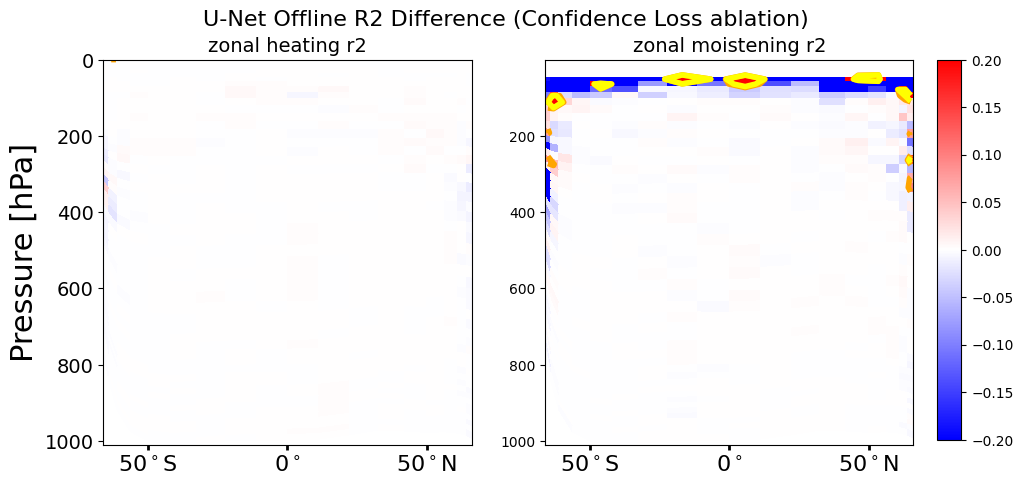

In [75]:
plot_zonal(data_v2_rh_mc, 
           standard_unet_zonal_heating_r2, 
           conf_loss_unet_zonal_heating_r2, 
           standard_unet_zonal_moistening_r2,
           conf_loss_unet_zonal_moistening_r2,
           'U-Net Offline R2 Difference (Confidence Loss ablation)', 
          )

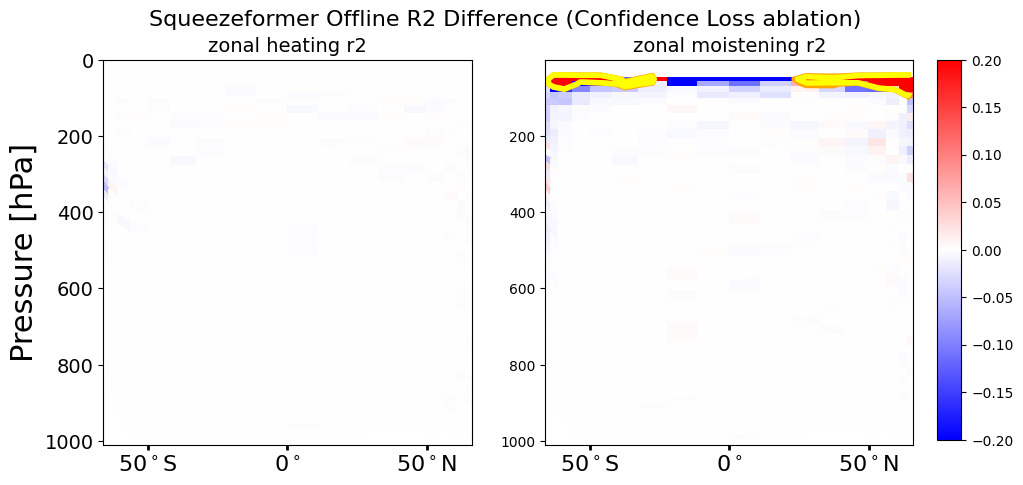

In [76]:
plot_zonal(data_v2_rh_mc, 
           standard_squeezeformer_zonal_heating_r2, 
           conf_loss_squeezeformer_zonal_heating_r2, 
           standard_squeezeformer_zonal_moistening_r2,
           conf_loss_squeezeformer_zonal_moistening_r2,
           'Squeezeformer Offline R2 Difference (Confidence Loss ablation)', 
          )

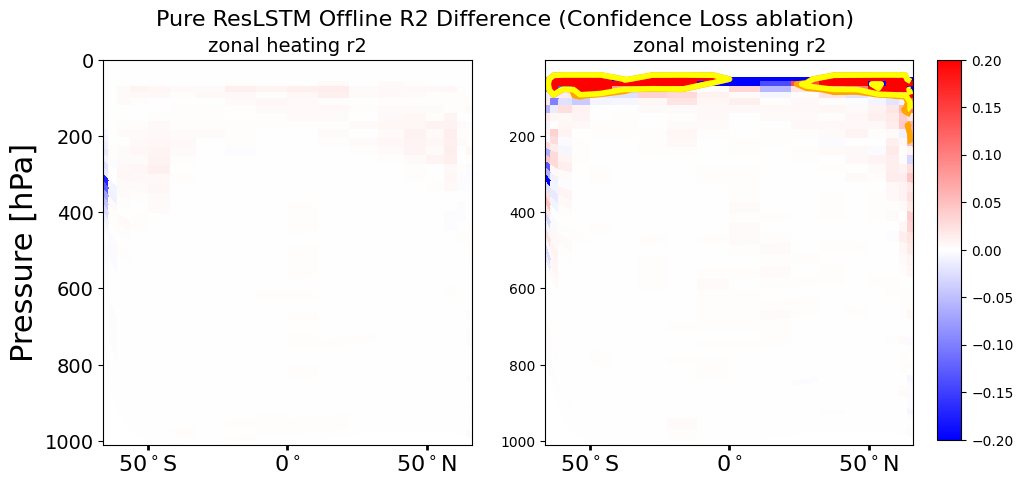

In [77]:
plot_zonal(data_v2_rh_mc, 
           standard_pure_resLSTM_zonal_heating_r2, 
           conf_loss_pure_resLSTM_zonal_heating_r2, 
           standard_pure_resLSTM_zonal_moistening_r2,
           conf_loss_pure_resLSTM_zonal_moistening_r2,
           'Pure ResLSTM Offline R2 Difference (Confidence Loss ablation)', 
          )

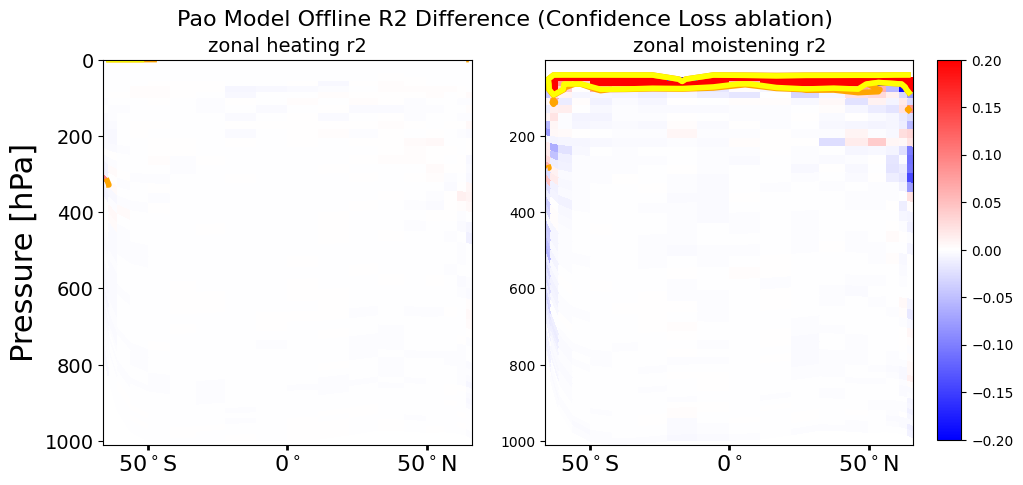

In [78]:
plot_zonal(data_v2_rh_mc, 
           standard_pao_model_zonal_heating_r2, 
           conf_loss_pao_model_zonal_heating_r2, 
           standard_pao_model_zonal_moistening_r2,
           conf_loss_pao_model_zonal_moistening_r2,
           'Pao Model Offline R2 Difference (Confidence Loss ablation)', 
          )

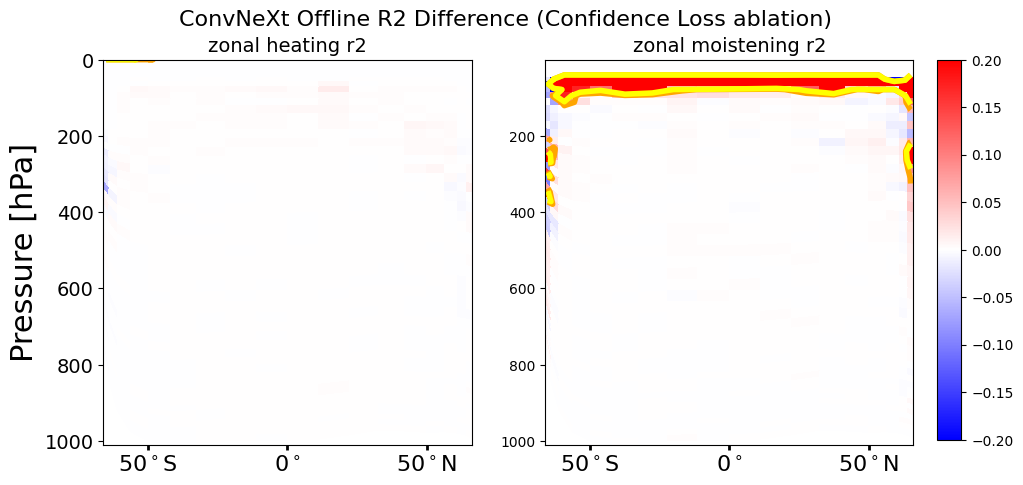

In [79]:
plot_zonal(data_v2_rh_mc, 
           standard_convnext_zonal_heating_r2, 
           conf_loss_convnext_zonal_heating_r2, 
           standard_convnext_zonal_moistening_r2,
           conf_loss_convnext_zonal_moistening_r2,
           'ConvNeXt Offline R2 Difference (Confidence Loss ablation)', 
          )

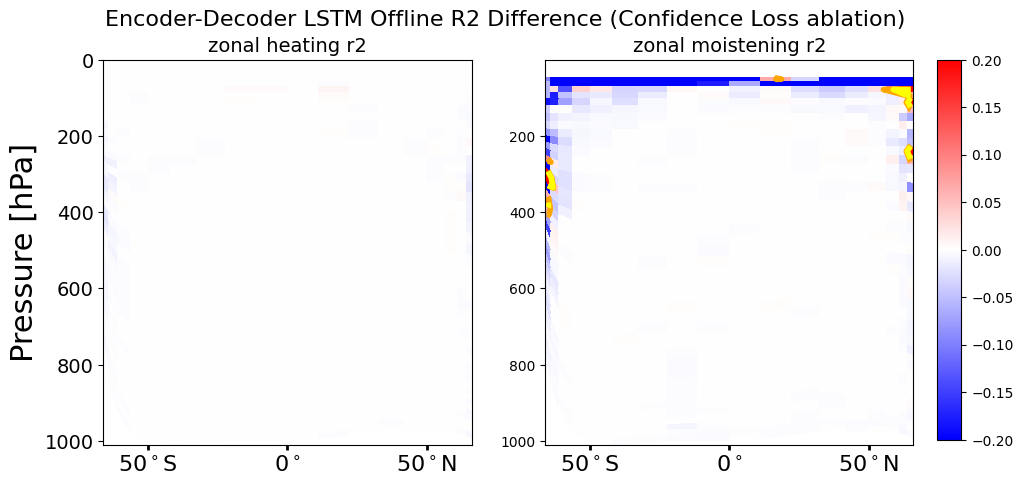

In [80]:
plot_zonal(data_v2_rh_mc, 
           standard_encdec_lstm_zonal_heating_r2, 
           conf_loss_encdec_lstm_zonal_heating_r2, 
           standard_encdec_lstm_zonal_moistening_r2,
           conf_loss_encdec_lstm_zonal_moistening_r2,
           'Encoder-Decoder LSTM Offline R2 Difference (Confidence Loss ablation)', 
          )

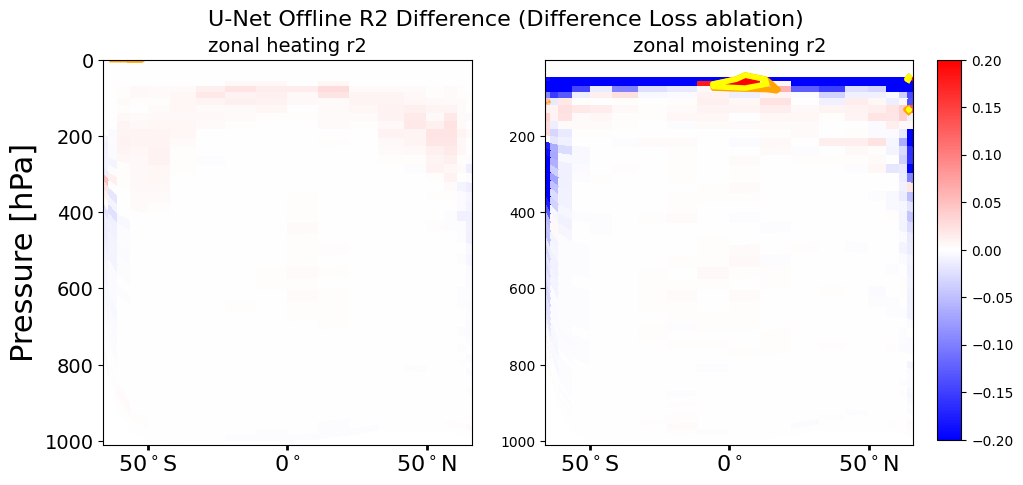

In [81]:
plot_zonal(data_v2_rh_mc, 
           standard_unet_zonal_heating_r2, 
           diff_loss_unet_zonal_heating_r2, 
           standard_unet_zonal_moistening_r2,
           diff_loss_unet_zonal_moistening_r2,
           'U-Net Offline R2 Difference (Difference Loss ablation)', 
          )

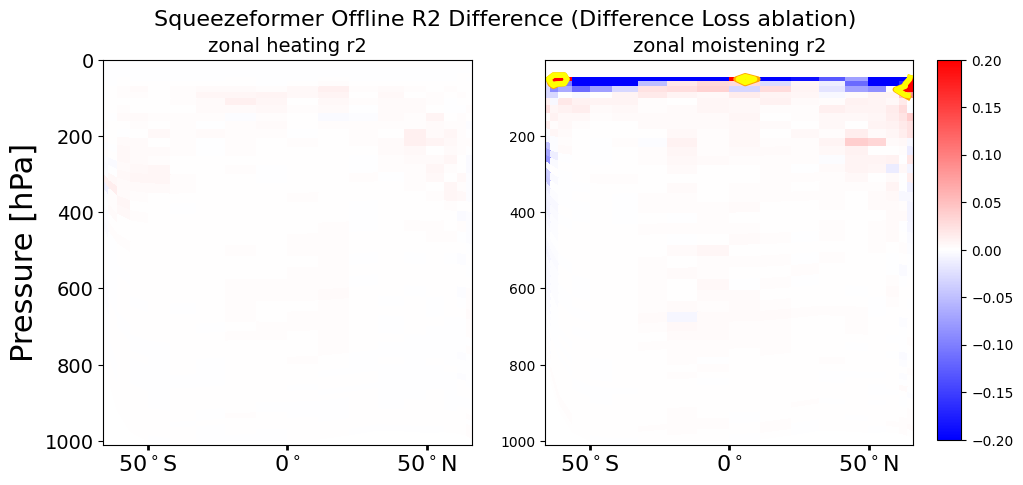

In [82]:
plot_zonal(data_v2_rh_mc, 
           standard_squeezeformer_zonal_heating_r2, 
           diff_loss_squeezeformer_zonal_heating_r2, 
           standard_squeezeformer_zonal_moistening_r2,
           diff_loss_squeezeformer_zonal_moistening_r2,
           'Squeezeformer Offline R2 Difference (Difference Loss ablation)', 
          )

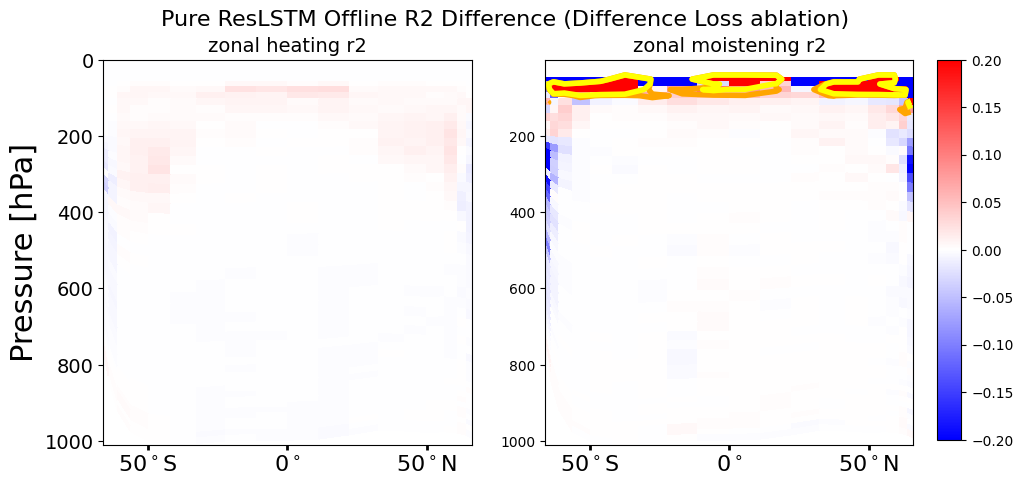

In [83]:
plot_zonal(data_v2_rh_mc, 
           standard_pure_resLSTM_zonal_heating_r2, 
           diff_loss_pure_resLSTM_zonal_heating_r2, 
           standard_pure_resLSTM_zonal_moistening_r2,
           diff_loss_pure_resLSTM_zonal_moistening_r2,
           'Pure ResLSTM Offline R2 Difference (Difference Loss ablation)', 
          )

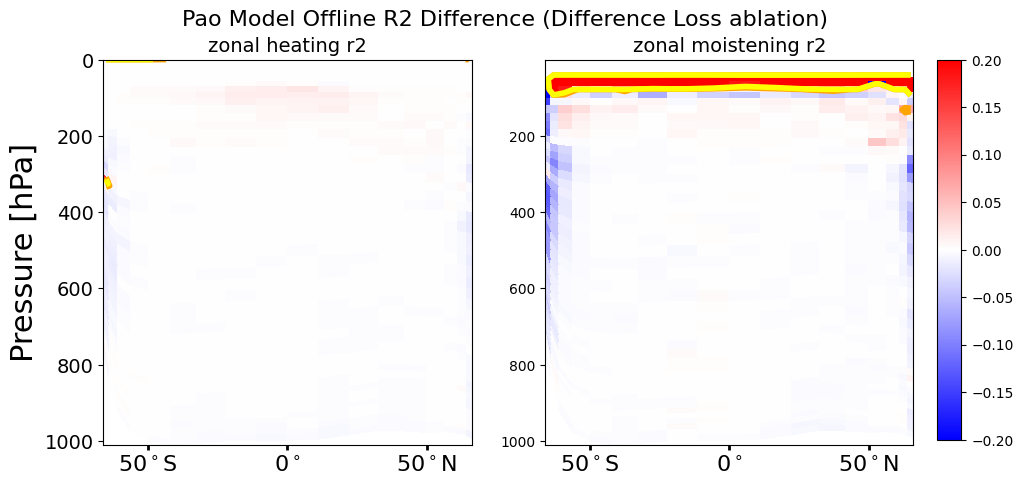

In [84]:
plot_zonal(data_v2_rh_mc, 
           standard_pao_model_zonal_heating_r2, 
           diff_loss_pao_model_zonal_heating_r2, 
           standard_pao_model_zonal_moistening_r2,
           diff_loss_pao_model_zonal_moistening_r2,
           'Pao Model Offline R2 Difference (Difference Loss ablation)', 
          )

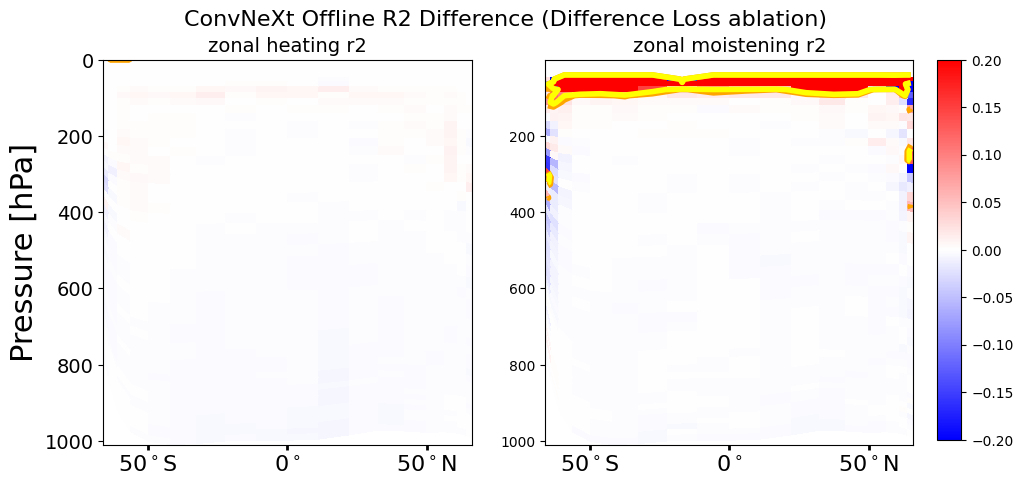

In [85]:
plot_zonal(data_v2_rh_mc, 
           standard_convnext_zonal_heating_r2, 
           diff_loss_convnext_zonal_heating_r2, 
           standard_convnext_zonal_moistening_r2,
           diff_loss_convnext_zonal_moistening_r2,
           'ConvNeXt Offline R2 Difference (Difference Loss ablation)', 
          )

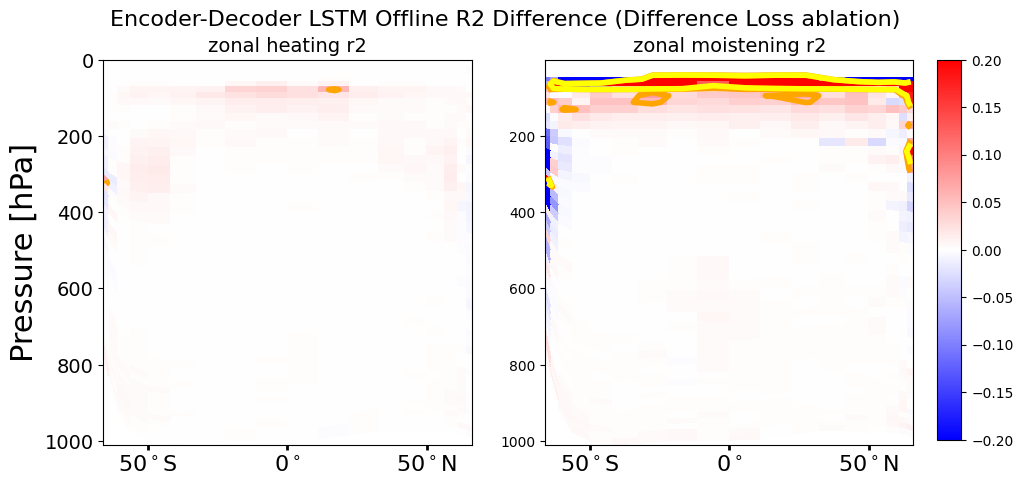

In [86]:
plot_zonal(data_v2_rh_mc, 
           standard_encdec_lstm_zonal_heating_r2, 
           diff_loss_encdec_lstm_zonal_heating_r2, 
           standard_encdec_lstm_zonal_moistening_r2,
           diff_loss_encdec_lstm_zonal_moistening_r2,
           'Encoder-Decoder LSTM Offline R2 Difference (Difference Loss ablation)', 
          )

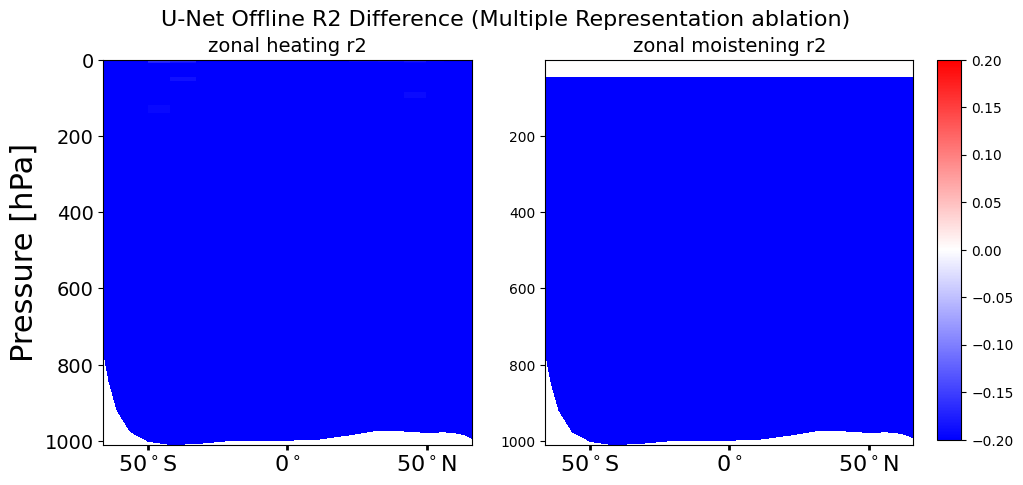

In [87]:
plot_zonal(data_v2_rh_mc, 
           standard_unet_zonal_heating_r2, 
           multirep_unet_zonal_heating_r2, 
           standard_unet_zonal_moistening_r2,
           multirep_unet_zonal_moistening_r2,
           'U-Net Offline R2 Difference (Multiple Representation ablation)', 
          )

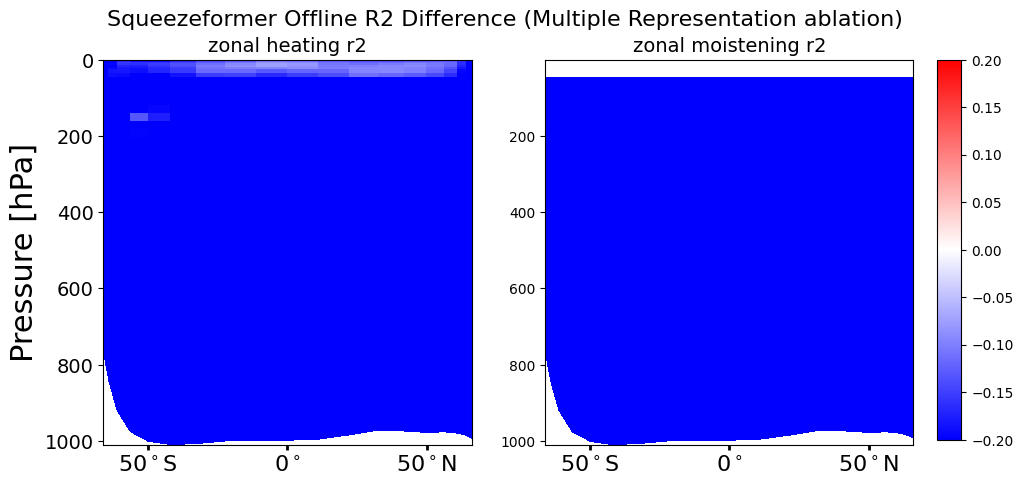

In [88]:
plot_zonal(data_v2_rh_mc, 
           standard_squeezeformer_zonal_heating_r2, 
           multirep_squeezeformer_zonal_heating_r2, 
           standard_squeezeformer_zonal_moistening_r2,
           multirep_squeezeformer_zonal_moistening_r2,
           'Squeezeformer Offline R2 Difference (Multiple Representation ablation)', 
          )

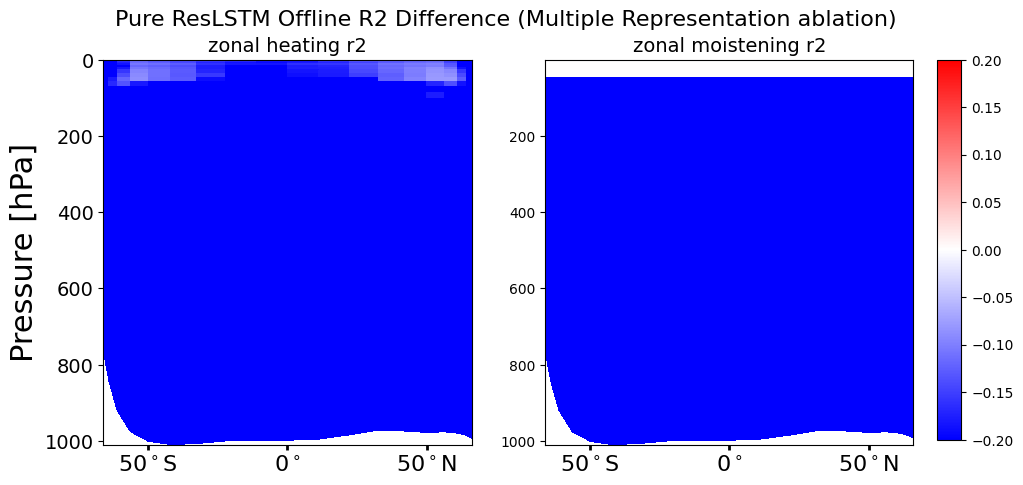

In [89]:
plot_zonal(data_v2_rh_mc, 
           standard_pure_resLSTM_zonal_heating_r2, 
           multirep_pure_resLSTM_zonal_heating_r2, 
           standard_pure_resLSTM_zonal_moistening_r2,
           multirep_pure_resLSTM_zonal_moistening_r2,
           'Pure ResLSTM Offline R2 Difference (Multiple Representation ablation)', 
          )

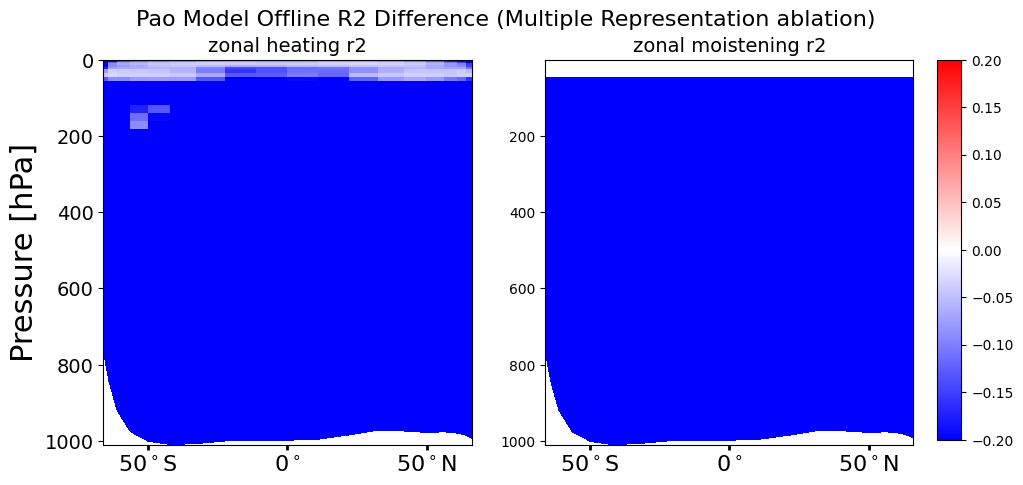

In [90]:
plot_zonal(data_v2_rh_mc, 
           standard_pao_model_zonal_heating_r2, 
           multirep_pao_model_zonal_heating_r2, 
           standard_pao_model_zonal_moistening_r2,
           multirep_pao_model_zonal_moistening_r2,
           'Pao Model Offline R2 Difference (Multiple Representation ablation)', 
          )

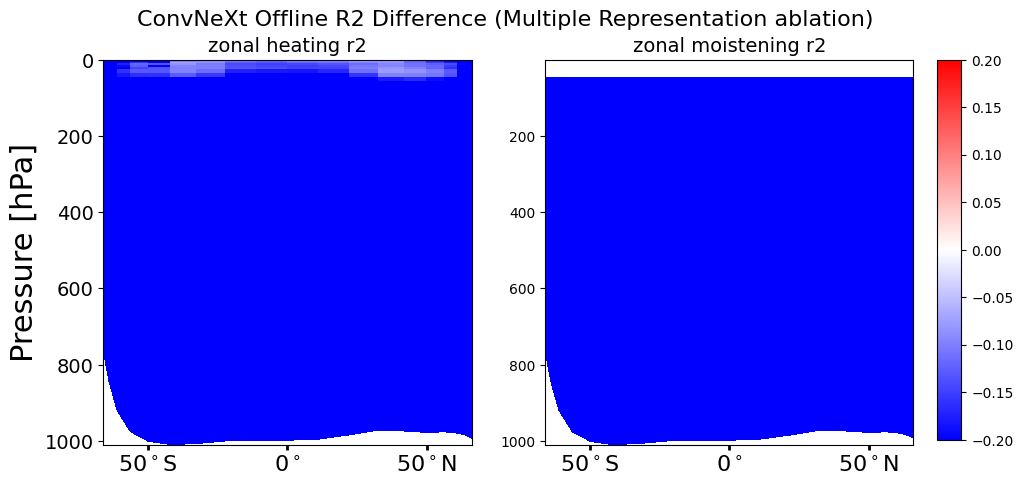

In [91]:
plot_zonal(data_v2_rh_mc, 
           standard_convnext_zonal_heating_r2, 
           multirep_convnext_zonal_heating_r2, 
           standard_convnext_zonal_moistening_r2,
           multirep_convnext_zonal_moistening_r2,
           'ConvNeXt Offline R2 Difference (Multiple Representation ablation)', 
          )

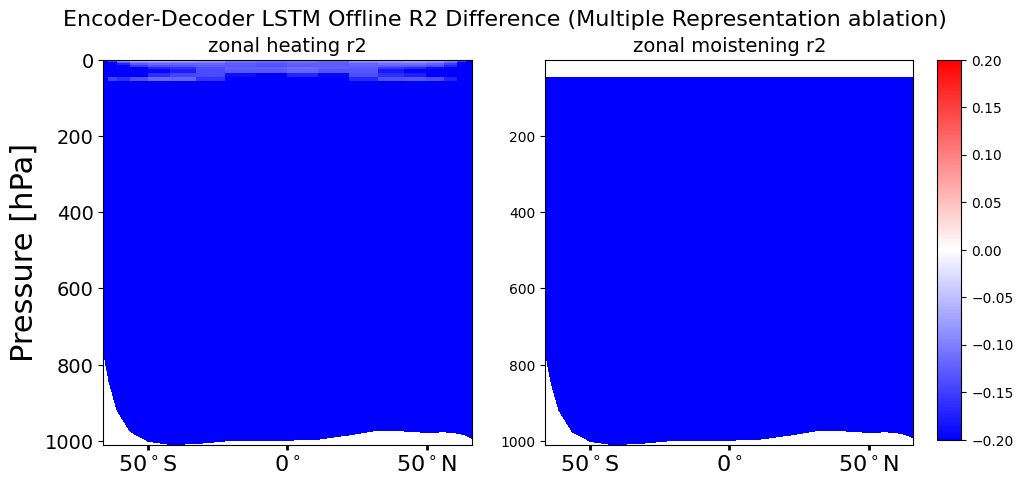

In [92]:
plot_zonal(data_v2_rh_mc, 
           standard_encdec_lstm_zonal_heating_r2, 
           multirep_encdec_lstm_zonal_heating_r2, 
           standard_encdec_lstm_zonal_moistening_r2,
           multirep_encdec_lstm_zonal_moistening_r2,
           'Encoder-Decoder LSTM Offline R2 Difference (Multiple Representation ablation)', 
          )

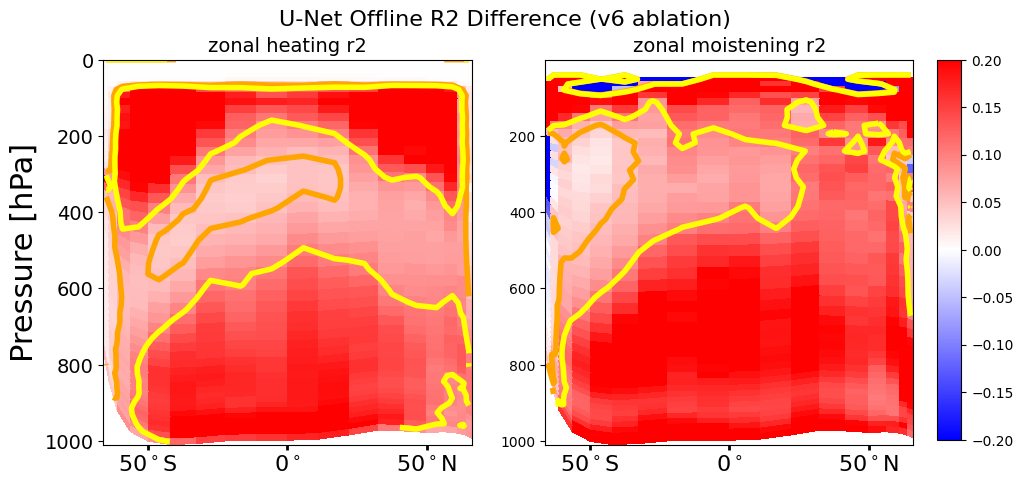

In [93]:
plot_zonal(data_v2_rh_mc, 
           standard_unet_zonal_heating_r2, 
           v6_unet_zonal_heating_r2, 
           standard_unet_zonal_moistening_r2,
           v6_unet_zonal_moistening_r2,
           'U-Net Offline R2 Difference (v6 ablation)', 
          )

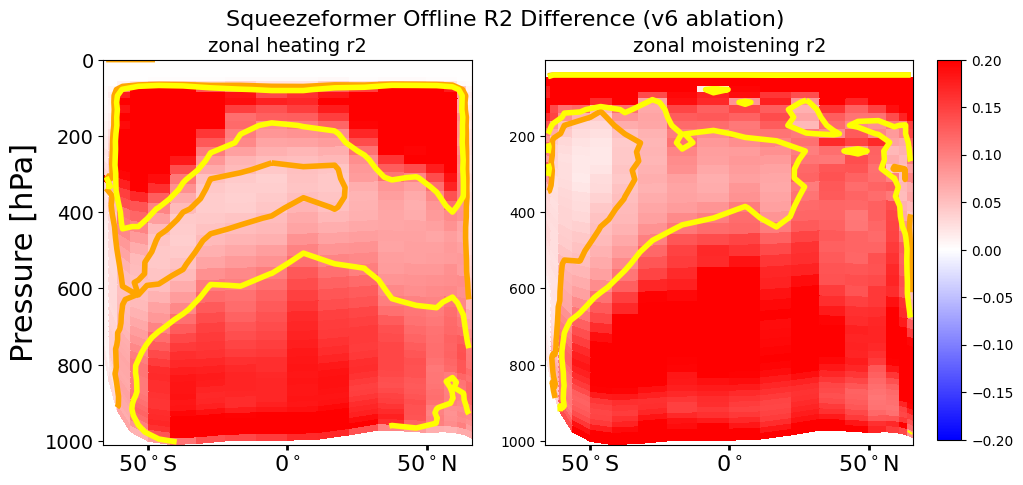

In [94]:
plot_zonal(data_v2_rh_mc, 
           standard_squeezeformer_zonal_heating_r2, 
           v6_squeezeformer_zonal_heating_r2, 
           standard_squeezeformer_zonal_moistening_r2,
           v6_squeezeformer_zonal_moistening_r2,
           'Squeezeformer Offline R2 Difference (v6 ablation)', 
          )

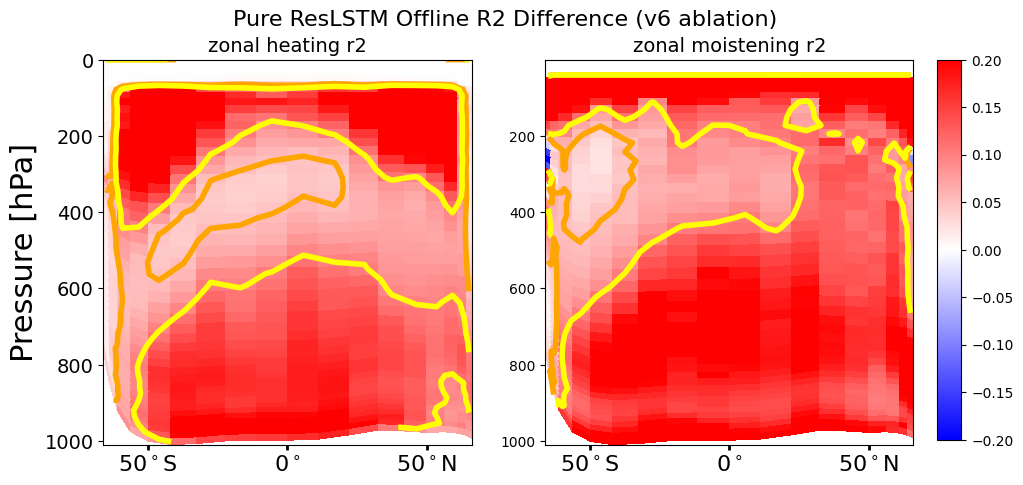

In [95]:
plot_zonal(data_v2_rh_mc, 
           standard_pure_resLSTM_zonal_heating_r2, 
           v6_pure_resLSTM_zonal_heating_r2, 
           standard_pure_resLSTM_zonal_moistening_r2,
           v6_pure_resLSTM_zonal_moistening_r2,
           'Pure ResLSTM Offline R2 Difference (v6 ablation)', 
          )

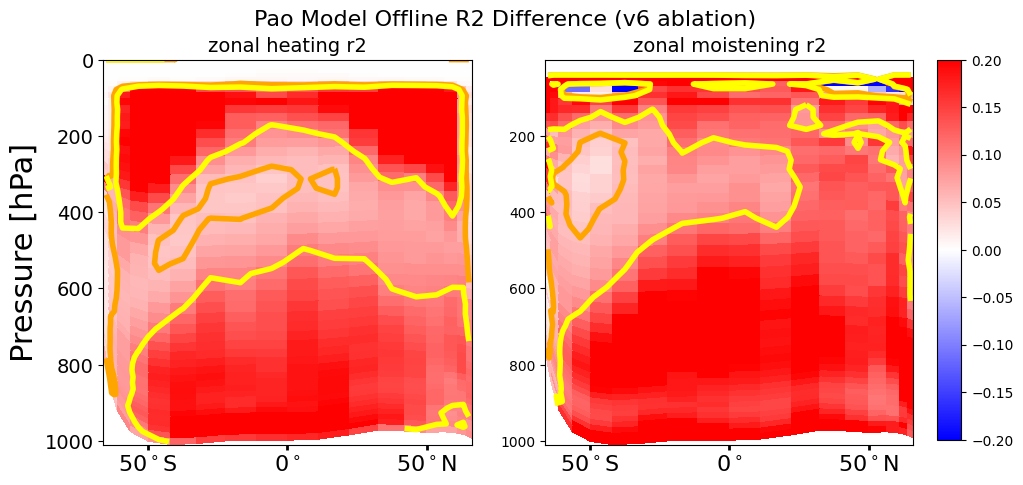

In [96]:
plot_zonal(data_v2_rh_mc, 
           standard_pao_model_zonal_heating_r2, 
           v6_pao_model_zonal_heating_r2, 
           standard_pao_model_zonal_moistening_r2,
           v6_pao_model_zonal_moistening_r2,
           'Pao Model Offline R2 Difference (v6 ablation)', 
          )

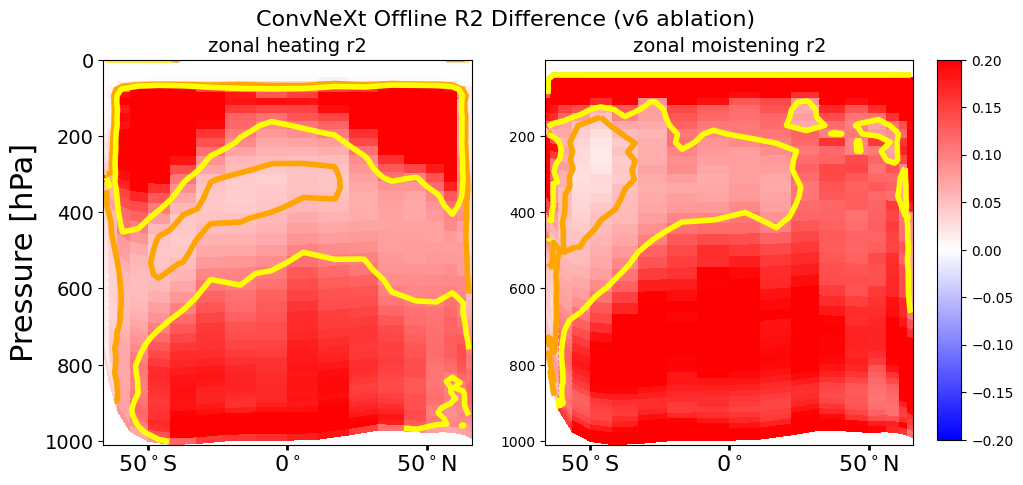

In [97]:
plot_zonal(data_v2_rh_mc, 
           standard_convnext_zonal_heating_r2, 
           v6_convnext_zonal_heating_r2, 
           standard_convnext_zonal_moistening_r2,
           v6_convnext_zonal_moistening_r2,
           'ConvNeXt Offline R2 Difference (v6 ablation)', 
          )

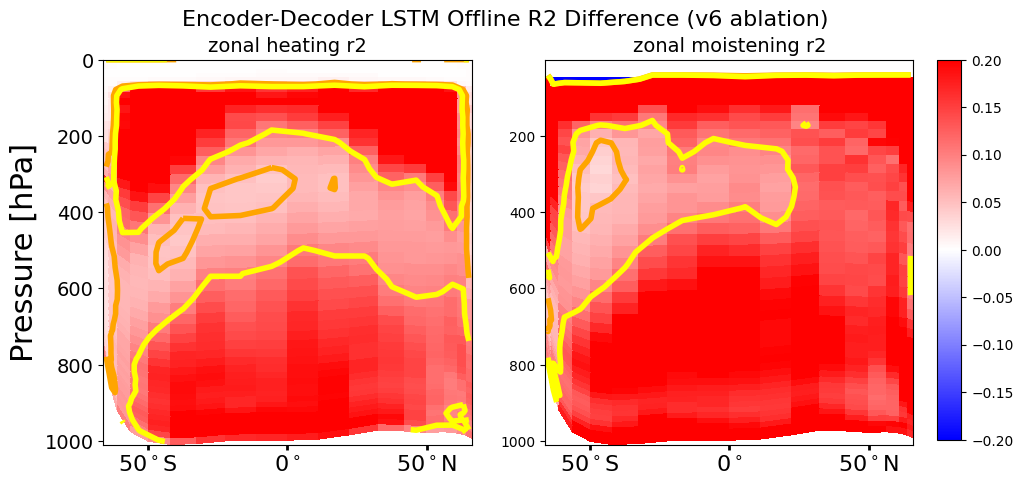

In [98]:
plot_zonal(data_v2_rh_mc, 
           standard_encdec_lstm_zonal_heating_r2, 
           v6_encdec_lstm_zonal_heating_r2, 
           standard_encdec_lstm_zonal_moistening_r2,
           v6_encdec_lstm_zonal_moistening_r2,
           'Encoder-Decoder LSTM Offline R2 Difference (v6 ablation)', 
          )

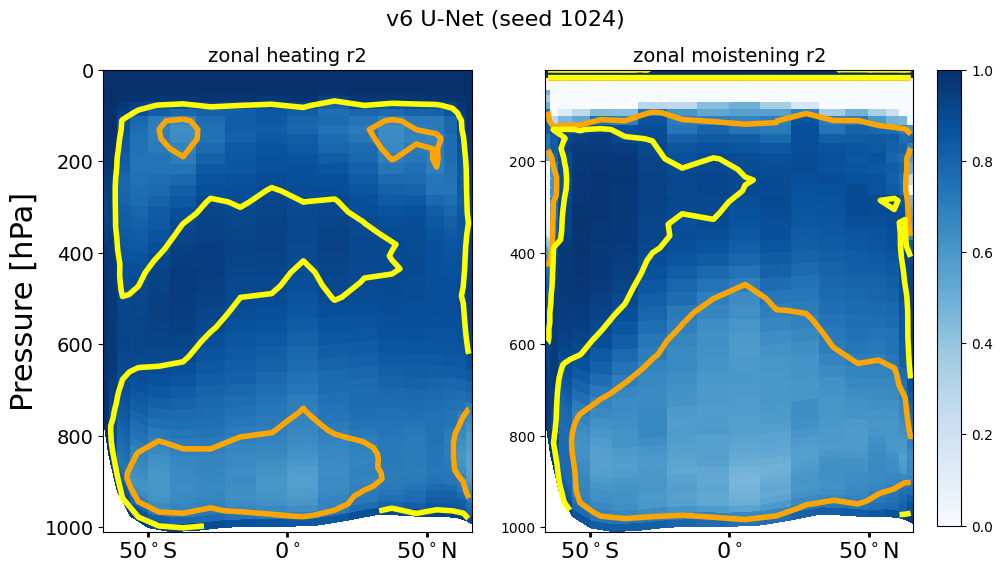

In [65]:
plot_zonal(data_v6.zonal_bin_weight_3d(v6_unet_zonal_heating_r2['seed_1024'])[0], 
           data_v6.zonal_bin_weight_3d(v6_unet_zonal_moistening_r2['seed_1024'])[0], 
           'v6 U-Net (seed 1024)')

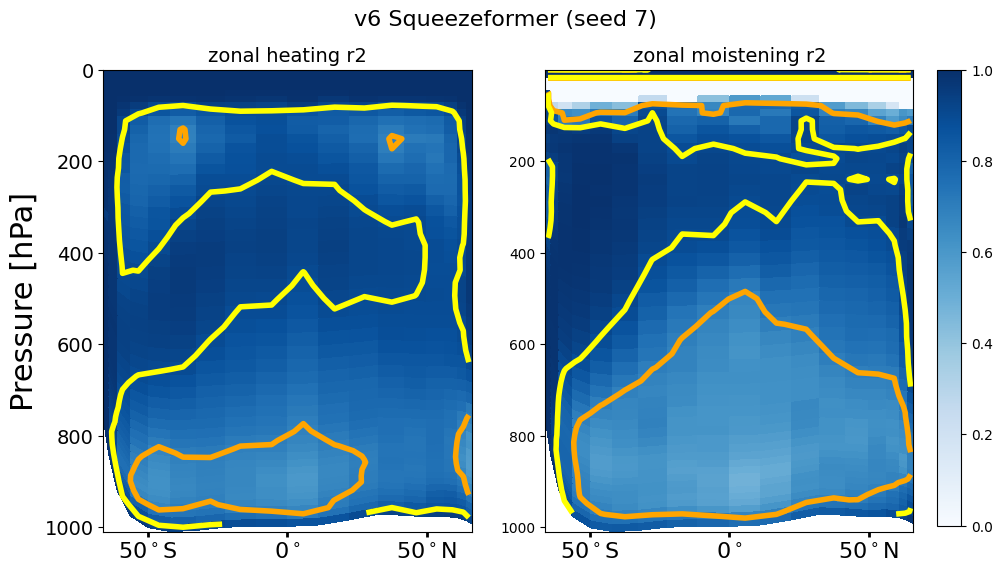

In [66]:
plot_zonal(data_v6.zonal_bin_weight_3d(v6_squeezeformer_zonal_heating_r2['seed_7'])[0], 
           data_v6.zonal_bin_weight_3d(v6_squeezeformer_zonal_moistening_r2['seed_7'])[0], 
           'v6 Squeezeformer (seed 7)')

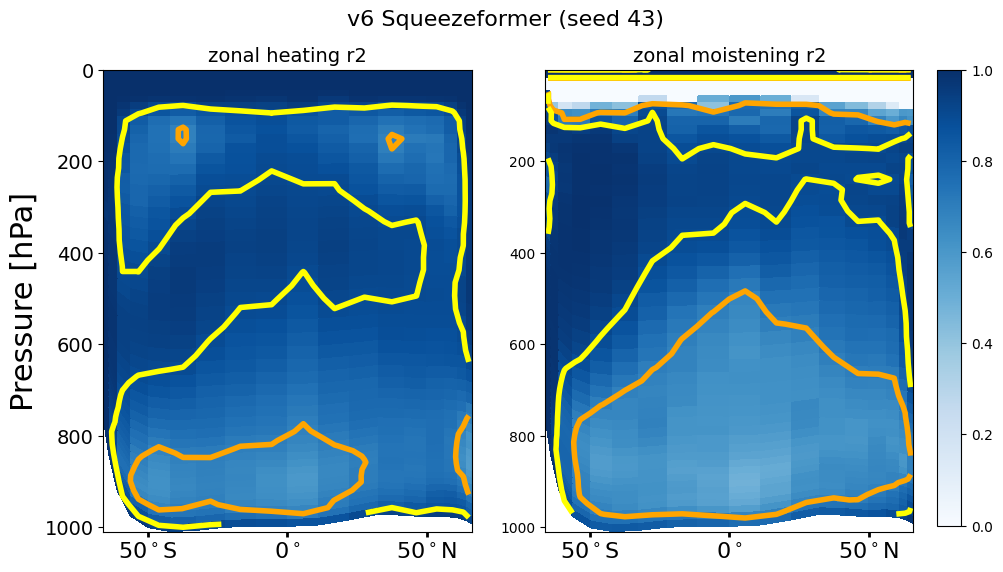

In [67]:
plot_zonal(data_v6.zonal_bin_weight_3d(v6_squeezeformer_zonal_heating_r2['seed_43'])[0], 
           data_v6.zonal_bin_weight_3d(v6_squeezeformer_zonal_moistening_r2['seed_43'])[0], 
           'v6 Squeezeformer (seed 43)')

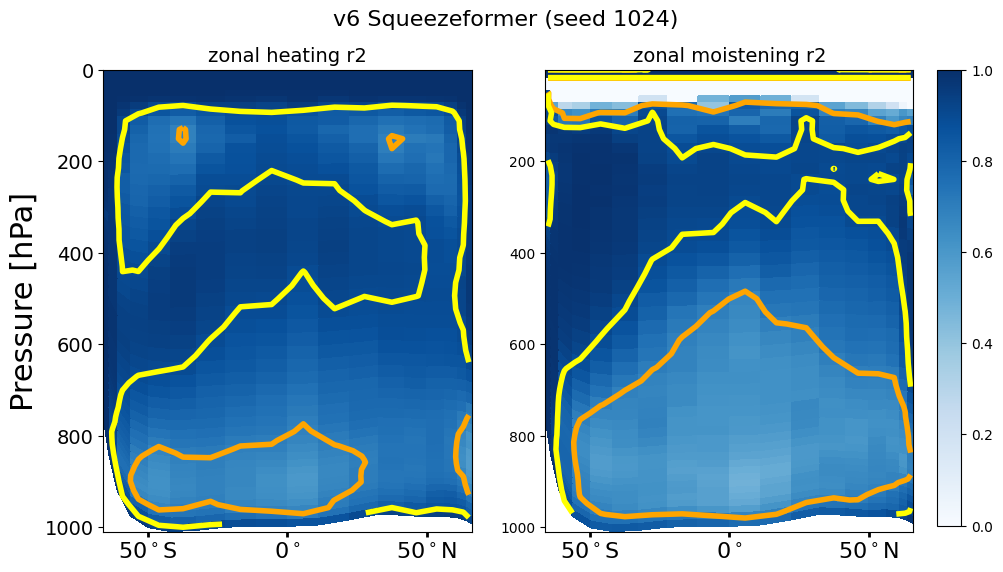

In [68]:
plot_zonal(data_v6.zonal_bin_weight_3d(v6_squeezeformer_zonal_heating_r2['seed_1024'])[0], 
           data_v6.zonal_bin_weight_3d(v6_squeezeformer_zonal_moistening_r2['seed_1024'])[0], 
           'v6 Squeezeformer (seed 1024)')

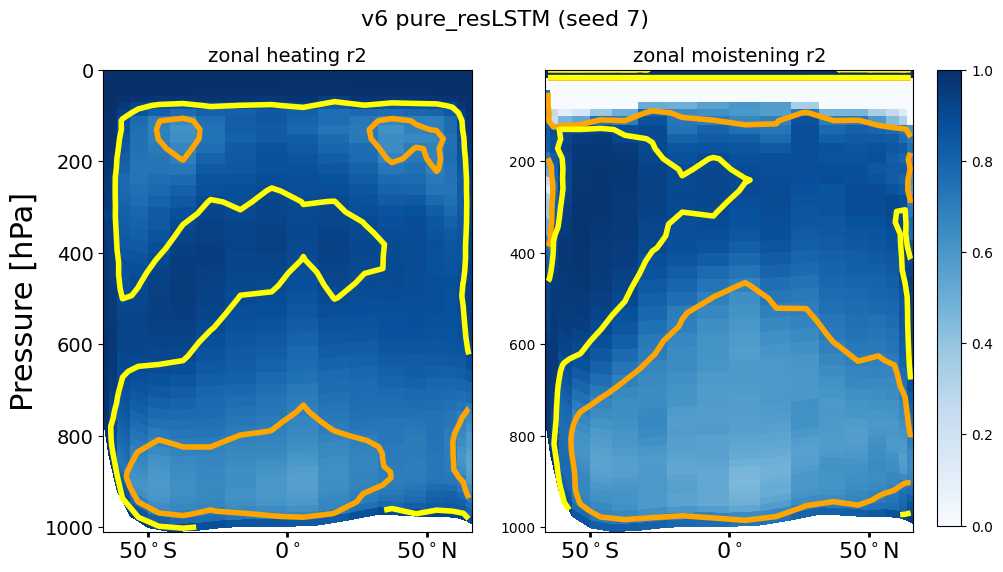

In [69]:
plot_zonal(data_v6.zonal_bin_weight_3d(v6_pure_resLSTM_zonal_heating_r2['seed_7'])[0], 
           data_v6.zonal_bin_weight_3d(v6_pure_resLSTM_zonal_moistening_r2['seed_7'])[0], 
           'v6 pure_resLSTM (seed 7)')

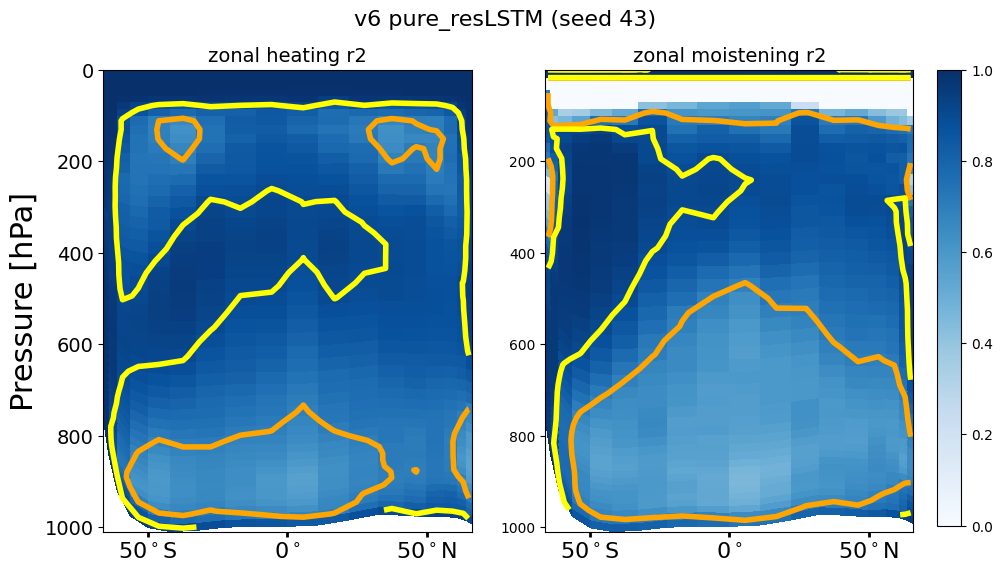

In [70]:
plot_zonal(data_v6.zonal_bin_weight_3d(v6_pure_resLSTM_zonal_heating_r2['seed_43'])[0], 
           data_v6.zonal_bin_weight_3d(v6_pure_resLSTM_zonal_moistening_r2['seed_43'])[0], 
           'v6 pure_resLSTM (seed 43)')

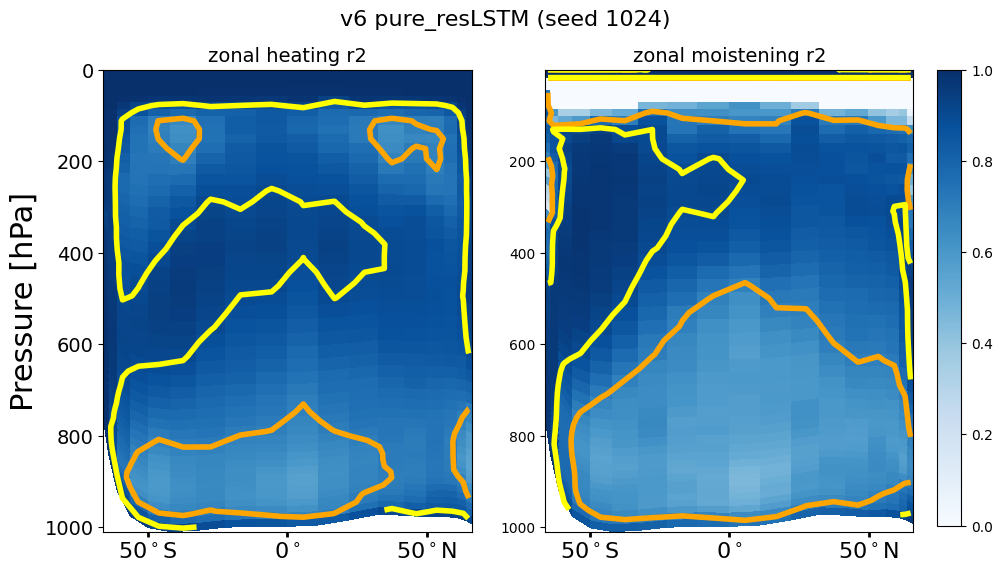

In [71]:
plot_zonal(data_v6.zonal_bin_weight_3d(v6_pure_resLSTM_zonal_heating_r2['seed_1024'])[0], 
           data_v6.zonal_bin_weight_3d(v6_pure_resLSTM_zonal_moistening_r2['seed_1024'])[0], 
           'v6 pure_resLSTM (seed 1024)')

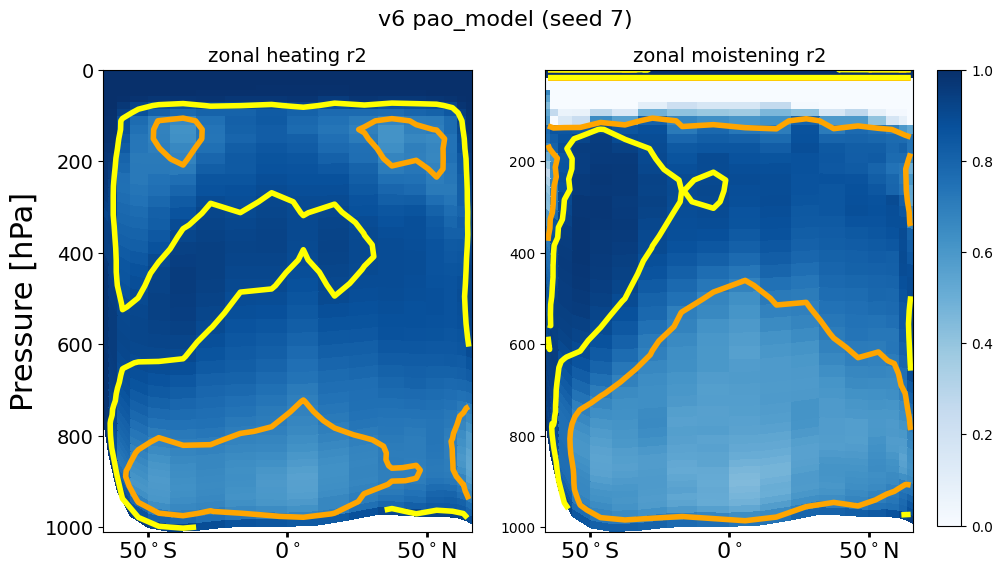

In [72]:
plot_zonal(data_v6.zonal_bin_weight_3d(v6_pao_model_zonal_heating_r2['seed_7'])[0], 
           data_v6.zonal_bin_weight_3d(v6_pao_model_zonal_moistening_r2['seed_7'])[0], 
           'v6 pao_model (seed 7)')

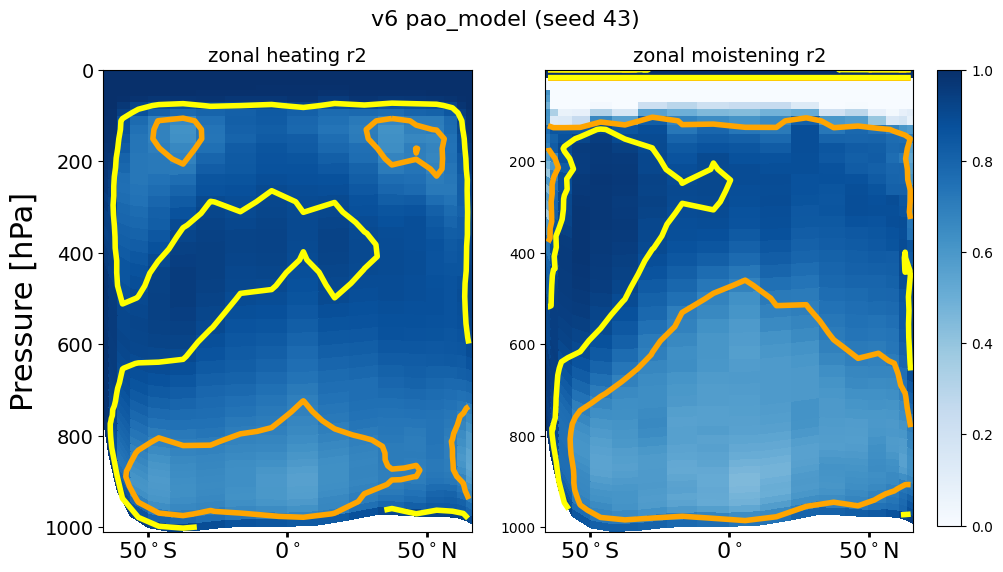

In [73]:
plot_zonal(data_v6.zonal_bin_weight_3d(v6_pao_model_zonal_heating_r2['seed_43'])[0], 
           data_v6.zonal_bin_weight_3d(v6_pao_model_zonal_moistening_r2['seed_43'])[0], 
           'v6 pao_model (seed 43)')

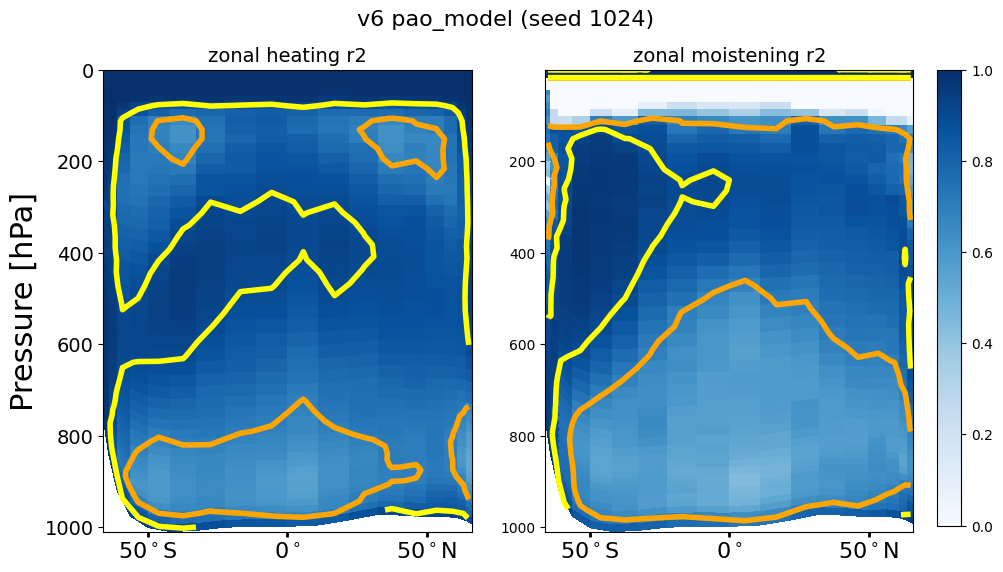

In [74]:
plot_zonal(data_v6.zonal_bin_weight_3d(v6_pao_model_zonal_heating_r2['seed_1024'])[0], 
           data_v6.zonal_bin_weight_3d(v6_pao_model_zonal_moistening_r2['seed_1024'])[0], 
           'v6 pao_model (seed 1024)')

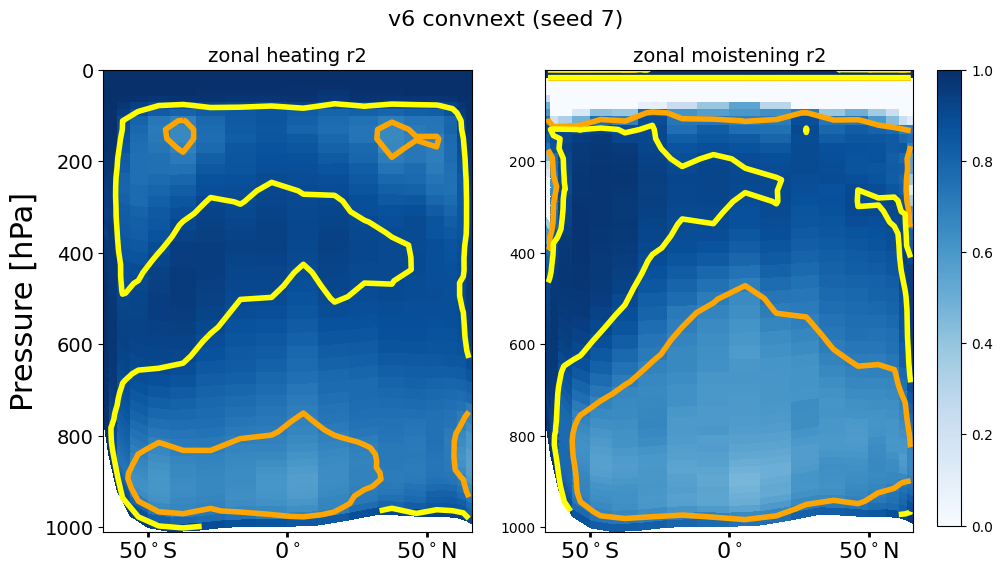

In [75]:
plot_zonal(data_v6.zonal_bin_weight_3d(v6_convnext_zonal_heating_r2['seed_7'])[0], 
           data_v6.zonal_bin_weight_3d(v6_convnext_zonal_moistening_r2['seed_7'])[0], 
           'v6 convnext (seed 7)')

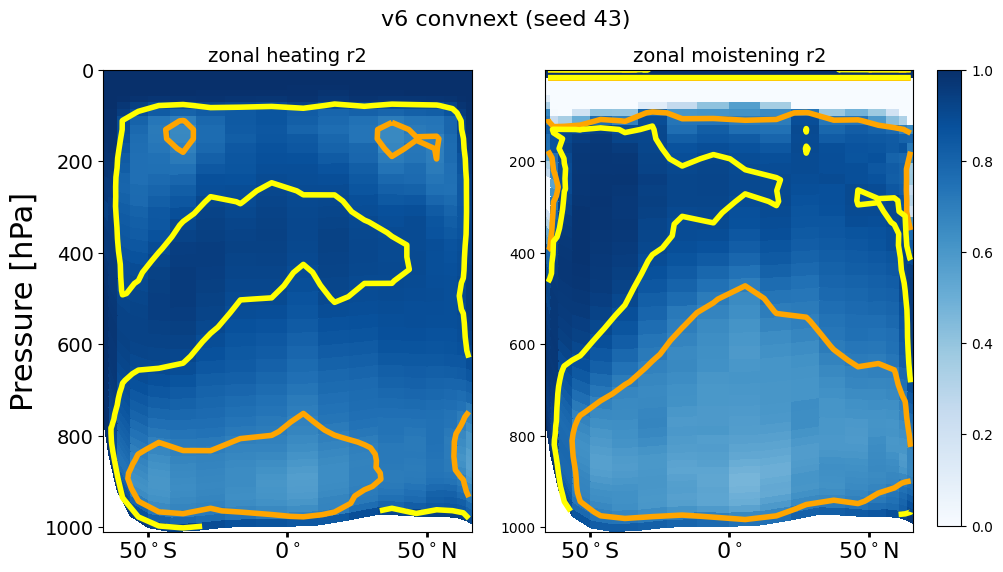

In [76]:
plot_zonal(data_v6.zonal_bin_weight_3d(v6_convnext_zonal_heating_r2['seed_43'])[0], 
           data_v6.zonal_bin_weight_3d(v6_convnext_zonal_moistening_r2['seed_43'])[0], 
           'v6 convnext (seed 43)')

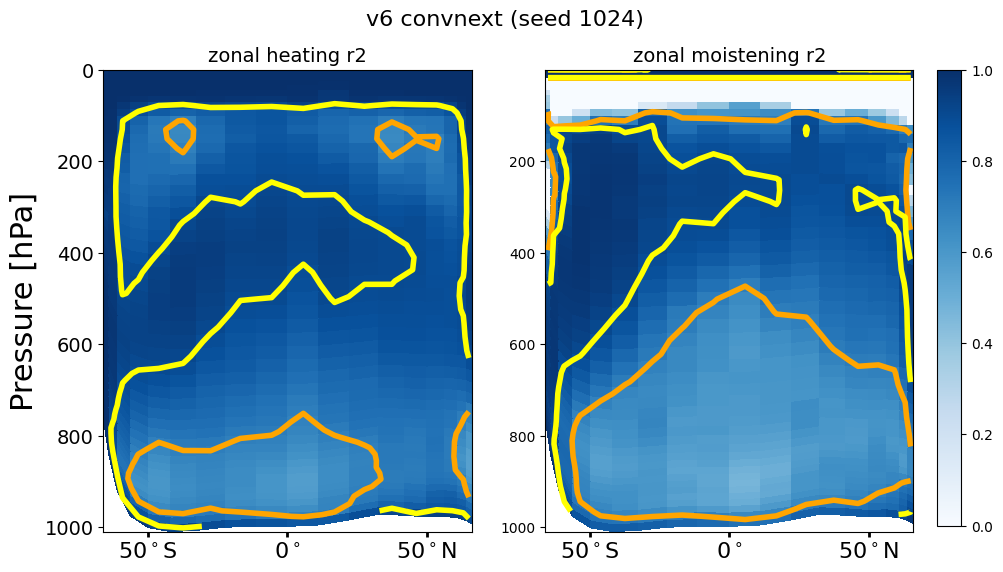

In [77]:
plot_zonal(data_v6.zonal_bin_weight_3d(v6_convnext_zonal_heating_r2['seed_1024'])[0], 
           data_v6.zonal_bin_weight_3d(v6_convnext_zonal_moistening_r2['seed_1024'])[0], 
           'v6 convnext (seed 1024)')

In [40]:
v6_unet_zonal_heating_r2['seed_7'][None,:,:].shape

(1, 384, 60)

In [45]:
data_v6.zonal_bin_weight_3d(v6_unet_zonal_heating_r2['seed_7'][None,:,:])[0].shape

(18, 60)

In [ ]:
fig, ax = plt.subplots(2, num_models, figsize = (num_models*12, 18))
y = np.arange(60)
X, Y = np.meshgrid(np.sin(np.pi*lat_bin_mids/180), y)
Y = (1/100) * np.mean(pressures_binned, axis = 0).T
for i, model_name in enumerate(model_paths.keys()):
    contour_plot_heating = ax[0,i].pcolor(X, Y, zonal_heating_r2[model_name].T, cmap='Blues', vmin = 0, vmax = 1)
    ax[0,i].contour(X, Y, zonal_heating_r2[model_name].T, [0.7], colors='orange', linewidths=[4])
    ax[0,i].contour(X, Y, zonal_heating_r2[model_name].T, [0.9], colors='yellow', linewidths=[4])
    ax[0,i].set_ylim(ax[0,i].get_ylim()[::-1])
    ax[0,i].set_title(f'{model_labels[model_name]} (heating)', fontsize = 20)
    ax[0,i].set_xticks([])
    contour_plot = ax[1,i].pcolor(X, Y, zonal_moistening_r2[model_name].T, cmap='Blues', vmin = 0, vmax = 1) # pcolormesh
    ax[1,i].contour(X, Y, zonal_moistening_r2[model_name].T, [0.7], colors='orange', linewidths=[4])
    ax[1,i].contour(X, Y, zonal_moistening_r2[model_name].T, [0.9], colors='yellow', linewidths=[4])
    ax[1,i].set_ylim(ax[1,i].get_ylim()[::-1])
    ax[1,i].set_title(f'{model_labels[model_name]} (moistening)', fontsize = 20)
    ax[1,i].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    ax[1,i].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'], fontsize = 16)
    ax[1,i].xaxis.set_tick_params(width = 2)
    if i != 0:
        ax[0,i].set_yticks([])
        ax[1,i].set_yticks([])
ax[0,0].set_ylabel("Pressure [hPa]", fontsize = 22)
ax[0,0].yaxis.set_label_coords(-0.2,-0.09) # (-1.38,-0.09)
ax[0,0].yaxis.set_tick_params(labelsize = 14)
ax[1,0].yaxis.set_tick_params(labelsize = 14)
ax[0,0].yaxis.set_ticks([1000,800,600,400,200,0])
ax[1,0].yaxis.set_ticks([1000,800,600,400,200,0])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.02, 0.76])
cb = fig.colorbar(contour_plot, cax=cbar_ax)
cb.set_label("Skill Score "+r'$\left(\mathrm{R^{2}}\right)$',labelpad=50.1, fontsize = 20)
plt.suptitle("Baseline Models Skill for Vertically Resolved Tendencies", y = 0.97, fontsize = 22)
plt.subplots_adjust(hspace=0.1)
plt.savefig(preds_path + 'press_lat_r2_models.png', bbox_inches='tight', pad_inches=0.1 , dpi = 300)
plt.clf()

In [ ]:
def get_coeff(target, pred):
    rss = np.sum((pred - target)**2, axis = 0)
    tss = np.sum((target - np.mean(target, axis = 0)[None,:,:])**2, axis = 0)
    coeff = 1 - rss/tss
    mask = tss == 0
    coeff[mask] = 1.0 * (rss[mask] == 0) 
    return coeff

print('Calculating zonal heating standard r2')
standard_unet_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], standard_preds['unet'](seed)[:,:,:60]) for seed in seeds}
standard_squeezeformer_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], standard_preds['squeezeformer'](seed)[:,:,:60]) for seed in seeds}
standard_pure_resLSTM_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], standard_preds['pure_resLSTM'](seed)[:,:,:60]) for seed in seeds}
standard_pao_model_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], standard_preds['pao_model'](seed)[:,:,:60]) for seed in seeds}
standard_convnext_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], standard_preds['convnext'](seed)[:,:,:60]) for seed in seeds}
standard_encdec_lstm_zonal_heating_r2 = {seed: get_coeff(actual_target[:,:,:60], standard_preds['encdec_lstm'](seed)[:,:,:60]) for seed in seeds}

for model_name in model_paths.keys():
    zonal_heating_r2[model_name] = data.zonal_bin_weight_3d(get_coeff(reshaped_target[:,:,:60], \
                                                                      model_preds[model_name][:,:,:60]))[0]
    zonal_moistening_r2[model_name] = data.zonal_bin_weight_3d(get_coeff(reshaped_target[:,:,60:120], \
                                                                          model_preds[model_name][:,:,60:120]))[0]

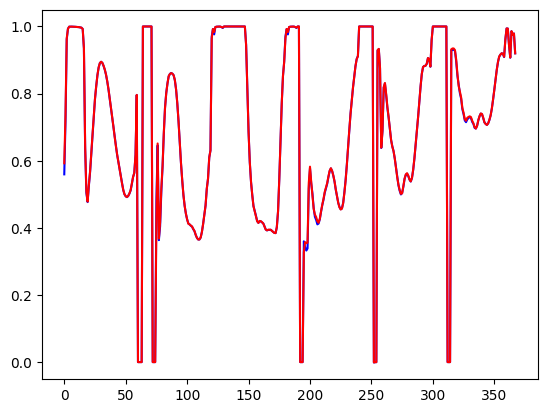

In [43]:
plt.plot(np.arange(368), standard_unet_r2['seed_1024'][0], color = 'blue')
plt.plot(np.arange(368), conf_loss_unet_r2['seed_1024'][0], color = 'red')

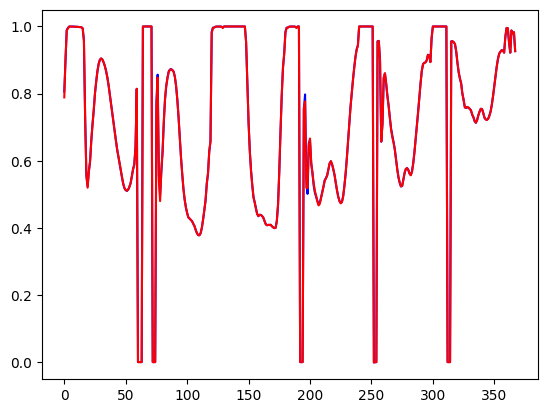

In [42]:
plt.plot(np.arange(368), standard_squeezeformer_r2['seed_1024'][0], color = 'blue')
plt.plot(np.arange(368), conf_loss_squeezeformer_r2['seed_1024'][0], color = 'red')

In [32]:
plt.figure(figsize=(10, 6))
for model_name in model_paths.keys():
    r2_scores[model_name], r2_scores_capped[model_name] = show_r2(reshaped_target, model_preds[model_name])
    label_text = f'{model_labels[model_name]}: {np.mean(r2_scores[model_name]):.3g}' 
    plt.plot(np.arange(data.target_feature_len), r2_scores[model_name], color = model_colors[model_name], label=f"{label_text}")
    
plt.legend()
plt.xlabel('Feature Index')
plt.ylabel(r'$R^2$ Score')
plt.title(r'$R^2$ Score Comparison')

feature_indices = [0, 60, 120, 180, 240, 300, 308]
feature_labels = ['dT', 'dQv', 'dQn (liq+ice)', 'dU', 'dV', 'scalars', '']
plt.xticks(ticks=feature_indices, labels=feature_labels)
plt.ylim(0, 1)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig(preds_path + 'r2_lines.png')
plt.clf()

(array([ 7.41743943e-01,  8.32475075e-01,  9.72013383e-01,  9.95127730e-01,
         9.99565316e-01,  9.99664164e-01,  9.99681352e-01,  9.99570370e-01,
         9.99377721e-01,  9.99108774e-01,  9.98808849e-01,  9.98480370e-01,
         9.98166764e-01,  9.97840078e-01,  9.97490402e-01,  9.95508133e-01,
         9.66564793e-01,  7.91328280e-01,  7.63404983e-01,  7.37816672e-01,
         7.41549252e-01,  7.49908242e-01,  7.80485126e-01,  8.07857936e-01,
         8.35441689e-01,  8.64047796e-01,  8.86874710e-01,  9.08108009e-01,
         9.23039069e-01,  9.33633854e-01,  9.38859387e-01,  9.39769715e-01,
         9.36779749e-01,  9.31985437e-01,  9.25080855e-01,  9.15905861e-01,
         9.03113185e-01,  8.86143355e-01,  8.68494907e-01,  8.48979746e-01,
         8.28057402e-01,  8.06147897e-01,  7.84551417e-01,  7.65913678e-01,
         7.50260558e-01,  7.33671438e-01,  7.16762934e-01,  6.98140150e-01,
         6.81156560e-01,  6.66230937e-01,  6.56975842e-01,  6.51719393e-01,
         6.5

In [ ]:
def get_coeff(target, pred):
    rss = np.sum((pred - target)**2, axis = 0)
    tss = np.sum((target - np.mean(target, axis = 0)[None,:,:])**2, axis = 0)
    coeff = 1 - rss/tss
    mask = tss == 0
    coeff[mask] = 1.0 * (rss[mask] == 0) 
    return coeff

for model_name in model_paths.keys():
    zonal_heating_r2[model_name] = data.zonal_bin_weight_3d(get_coeff(reshaped_target[:,:,:60], \
                                                                      model_preds[model_name][:,:,:60]))[0]
    zonal_moistening_r2[model_name] = data.zonal_bin_weight_3d(get_coeff(reshaped_target[:,:,60:120], \
                                                                          model_preds[model_name][:,:,60:120]))[0]

In [14]:
def show_r2(target, preds):
    assert target.shape == preds.shape, f'target shape {target.shape} does not match preds shape {preds.shape}'
    new_shape = (np.prod(target.shape[:-1]), target.shape[-1])
    target_flattened = target.reshape(new_shape)
    preds_flattened = preds.reshape(new_shape)
    r2_scores = np.array([r2_score(target_flattened[:, i], preds_flattened[:, i]) for i in range(368)])
    r2_scores_capped = r2_scores.copy()
    r2_scores_capped[r2_scores_capped < 0] = 0
    return r2_scores, r2_scores_capped

r2_scores, r2_scores_capped = show_r2(actual_target, standard_preds['unet']('seed_7'))

In [9]:
standard_preds = {
    'unet': lambda seed_key: load_seed_data(standard_save_path, 'standard_unet_preds.npz', seed_key)
}
r2_scores_A, r2_scores_capped_A = show_r2(actual_target, standard_preds['unet']('seed_7'))

In [10]:
np.array_equal(r2_scores, r2_scores_A)

True

In [11]:
np.array_equal(r2_scores_capped, r2_scores_capped_A)

True

In [ ]:
def show_r2(target, preds):
    assert target.shape == preds.shape, f'target shape {target.shape} does not match preds shape {preds.shape}'
    new_shape = (np.prod(target.shape[:-1]), target.shape[-1])
    target_flattened = target.reshape(new_shape)
    preds_flattened = preds.reshape(new_shape)
    r2_scores = np.array([r2_score(target_flattened[:, i], preds_flattened[:, i]) for i in range(368)])
    r2_scores_capped = r2_scores.copy()
    r2_scores_capped[r2_scores_capped < 0] = 0
    return r2_scores, r2_scores_capped

plt.figure(figsize=(10, 6))
for model_name in model_paths.keys():
    r2_scores[model_name], r2_scores_capped[model_name] = show_r2(reshaped_target, model_preds[model_name])
    label_text = f'{model_labels[model_name]}: {np.mean(r2_scores[model_name]):.3g}' 
    plt.plot(np.arange(data.target_feature_len), r2_scores[model_name], color = model_colors[model_name], label=f"{label_text}")
    
plt.legend()
plt.xlabel('Feature Index')
plt.ylabel(r'$R^2$ Score')
plt.title(r'$R^2$ Score Comparison')

feature_indices = [0, 60, 120, 180, 240, 300, 308]
feature_labels = ['dT', 'dQv', 'dQn (liq+ice)', 'dU', 'dV', 'scalars', '']
plt.xticks(ticks=feature_indices, labels=feature_labels)
plt.ylim(0, 1)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig(preds_path + 'r2_lines.png')
plt.clf()


In [ ]:
# plot zonal diff
def plot_zonal_avg_diff(data, start_idx, end_idx, var_str):

    print('Calculating standard zonal r2')
    standard_unet_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], standard_preds['unet'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    standard_squeezeformer_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], standard_preds['squeezeformer'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    standard_pure_resLSTM_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], standard_preds['pure_resLSTM'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    standard_pao_model_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], standard_preds['pao_model'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    standard_convnext_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], standard_preds['convnext'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    standard_encdec_lstm_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], standard_preds['encdec_lstm'](seed)[:,:,start_idx:end_idx]) for seed in seeds}

    print('Calculating conf loss zonal r2')
    conf_loss_unet_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], conf_loss_preds['unet'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    conf_loss_squeezeformer_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], conf_loss_preds['squeezeformer'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    conf_loss_pure_resLSTM_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], conf_loss_preds['pure_resLSTM'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    conf_loss_pao_model_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], conf_loss_preds['pao_model'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    conf_loss_convnext_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], conf_loss_preds['convnext'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    conf_loss_encdec_lstm_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], conf_loss_preds['encdec_lstm'](seed)[:,:,start_idx:end_idx]) for seed in seeds}

    print('Calculating diff loss zonal r2')
    diff_loss_unet_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], diff_loss_preds['unet'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    diff_loss_squeezeformer_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], diff_loss_preds['squeezeformer'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    diff_loss_pure_resLSTM_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], diff_loss_preds['pure_resLSTM'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    diff_loss_pao_model_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], diff_loss_preds['pao_model'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    diff_loss_convnext_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], diff_loss_preds['convnext'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    diff_loss_encdec_lstm_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], diff_loss_preds['encdec_lstm'](seed)[:,:,start_idx:end_idx]) for seed in seeds}

    print('Calculating multirep zonal r2')
    multirep_unet_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], multirep_preds['unet'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    multirep_squeezeformer_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], multirep_preds['squeezeformer'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    multirep_pure_resLSTM_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], multirep_preds['pure_resLSTM'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    multirep_pao_model_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], multirep_preds['pao_model'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    multirep_convnext_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], multirep_preds['convnext'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    multirep_encdec_lstm_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], multirep_preds['encdec_lstm'](seed)[:,:,start_idx:end_idx]) for seed in seeds}

    print('Calculating v6 zonal r2')
    v6_unet_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], v6_preds['unet'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    v6_squeezeformer_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], v6_preds['squeezeformer'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    v6_pure_resLSTM_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], v6_preds['pure_resLSTM'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    v6_pao_model_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], v6_preds['pao_model'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    v6_convnext_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], v6_preds['convnext'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    v6_encdec_lstm_zonal_r2 = {seed: get_coeff(actual_target[:,:,start_idx:end_idx], v6_preds['encdec_lstm'](seed)[:,:,start_idx:end_idx]) for seed in seeds}
    
    standard_unet_avg_zonal_r2 = data.zonal_bin_weight_3d(np.mean(np.stack([standard_unet_zonal_r2[seed] for seed in seeds]), axis = 0))[0]
    standard_squeezeformer_avg_zonal_r2 = data.zonal_bin_weight_3d(np.mean(np.stack([standard_squeezeformer_zonal_r2[seed] for seed in seeds]), axis = 0))[0]
    standard_pure_resLSTM_avg_zonal_r2 = data.zonal_bin_weight_3d(np.mean(np.stack([standard_pure_resLSTM_zonal_r2[seed] for seed in seeds]), axis = 0))[0]
    standard_pao_model_avg_zonal_r2 = data.zonal_bin_weight_3d(np.mean(np.stack([standard_pao_model_zonal_r2[seed] for seed in seeds]), axis = 0))[0]
    standard_convnext_avg_zonal_r2 = data.zonal_bin_weight_3d(np.mean(np.stack([standard_convnext_zonal_r2[seed] for seed in seeds]), axis = 0))[0]
    standard_encdec_lstm_avg_zonal_r2 = data.zonal_bin_weight_3d(np.mean(np.stack([standard_encdec_lstm_zonal_r2[seed] for seed in seeds]), axis = 0))[0]

    conf_loss_unet_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([conf_loss_unet_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_unet_avg_zonal_r2
    conf_loss_squeezeformer_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([conf_loss_squeezeformer_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_squeezeformer_avg_zonal_r2
    conf_loss_pure_resLSTM_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([conf_loss_pure_resLSTM_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_pure_resLSTM_avg_zonal_r2
    conf_loss_pao_model_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([conf_loss_pao_model_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_pao_model_avg_zonal_r2
    conf_loss_convnext_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([conf_loss_convnext_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_convnext_avg_zonal_r2
    conf_loss_encdec_lstm_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([conf_loss_encdec_lstm_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_encdec_lstm_avg_zonal_r2

    diff_loss_unet_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([diff_loss_unet_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_unet_avg_zonal_r2
    diff_loss_squeezeformer_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([diff_loss_squeezeformer_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_squeezeformer_avg_zonal_r2
    diff_loss_pure_resLSTM_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([diff_loss_pure_resLSTM_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_pure_resLSTM_avg_zonal_r2
    diff_loss_pao_model_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([diff_loss_pao_model_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_pao_model_avg_zonal_r2
    diff_loss_convnext_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([diff_loss_convnext_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_convnext_avg_zonal_r2
    diff_loss_encdec_lstm_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([diff_loss_encdec_lstm_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_encdec_lstm_avg_zonal_r2

    multirep_unet_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([multirep_unet_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_unet_avg_zonal_r2
    multirep_squeezeformer_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([multirep_squeezeformer_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_squeezeformer_avg_zonal_r2
    multirep_pure_resLSTM_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([multirep_pure_resLSTM_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_pure_resLSTM_avg_zonal_r2
    multirep_pao_model_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([multirep_pao_model_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_pao_model_avg_zonal_r2
    multirep_convnext_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([multirep_convnext_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_convnext_avg_zonal_r2
    multirep_encdec_lstm_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([multirep_encdec_lstm_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_encdec_lstm_avg_zonal_r2

    v6_unet_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([v6_unet_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_unet_avg_zonal_r2
    v6_squeezeformer_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([v6_squeezeformer_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_squeezeformer_avg_zonal_r2
    v6_pure_resLSTM_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([v6_pure_resLSTM_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_pure_resLSTM_avg_zonal_r2
    v6_pao_model_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([v6_pao_model_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_pao_model_avg_zonal_r2
    v6_convnext_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([v6_convnext_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_convnext_avg_zonal_r2
    v6_encdec_lstm_avg_zonal_r2_diff = data.zonal_bin_weight_3d(np.mean(np.stack([v6_encdec_lstm_zonal_r2[seed] for seed in seeds]), axis = 0))[0] - standard_encdec_lstm_avg_zonal_r2

    fig, ax = plt.subplots(4, 6, figsize = (12, 24))
    y = np.arange(60)
    X, Y = np.meshgrid(np.sin(np.pi*lat_bin_mids/180), y)
    Y = (1/100) * np.mean(pressures_binned, axis = 0).T
    
    conf_loss_unet_diff_contour_plot = ax[0,0].pcolor(X, Y, conf_loss_unet_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    conf_loss_squeezeformer_diff_contour_plot = ax[0,1].pcolor(X, Y, conf_loss_squeezeformer_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    conf_loss_pure_resLSTM_diff_contour_plot = ax[0,2].pcolor(X, Y, conf_loss_pure_resLSTM_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    conf_loss_pao_model_diff_contour_plot = ax[0,3].pcolor(X, Y, conf_loss_pao_model_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    conf_loss_convnext_diff_contour_plot = ax[0,4].pcolor(X, Y, conf_loss_convnext_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    conf_loss_encdec_lstm_diff_contour_plot = ax[0,5].pcolor(X, Y, conf_loss_encdec_lstm_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)

    diff_loss_unet_diff_contour_plot = ax[1,0].pcolor(X, Y, diff_loss_unet_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    diff_loss_squeezeformer_diff_contour_plot = ax[1,1].pcolor(X, Y, diff_loss_squeezeformer_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    diff_loss_pure_resLSTM_diff_contour_plot = ax[1,2].pcolor(X, Y, diff_loss_pure_resLSTM_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    diff_loss_pao_model_diff_contour_plot = ax[1,3].pcolor(X, Y, diff_loss_pao_model_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    diff_loss_convnext_diff_contour_plot = ax[1,4].pcolor(X, Y, diff_loss_convnext_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    diff_loss_encdec_lstm_diff_contour_plot = ax[1,5].pcolor(X, Y, diff_loss_encdec_lstm_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)

    multirep_unet_diff_contour_plot = ax[2,0].pcolor(X, Y, multirep_unet_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    multirep_squeezeformer_diff_contour_plot = ax[2,1].pcolor(X, Y, multirep_squeezeformer_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    multirep_pure_resLSTM_diff_contour_plot = ax[2,2].pcolor(X, Y, multirep_pure_resLSTM_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    multirep_pao_model_diff_contour_plot = ax[2,3].pcolor(X, Y, multirep_pao_model_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    multirep_convnext_diff_contour_plot = ax[2,4].pcolor(X, Y, multirep_convnext_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    multirep_encdec_lstm_diff_contour_plot = ax[2,5].pcolor(X, Y, multirep_encdec_lstm_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)

    v6_unet_diff_contour_plot = ax[3,0].pcolor(X, Y, v6_unet_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    v6_squeezeformer_diff_contour_plot = ax[3,1].pcolor(X, Y, v6_squeezeformer_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    v6_pure_resLSTM_diff_contour_plot = ax[3,2].pcolor(X, Y, v6_pure_resLSTM_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    v6_pao_model_diff_contour_plot = ax[3,3].pcolor(X, Y, v6_pao_model_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    v6_convnext_diff_contour_plot = ax[3,4].pcolor(X, Y, v6_convnext_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    v6_encdec_lstm_diff_contour_plot = ax[3,5].pcolor(X, Y, v6_encdec_lstm_avg_zonal_r2_diff.T, cmap='bwr', vmin = -.2, vmax = .2)
    
    ax[0,0].contour(X, Y, conf_loss_unet_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[0,0].contour(X, Y, conf_loss_unet_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[0,1].contour(X, Y, conf_loss_squeezeformer_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[0,1].contour(X, Y, conf_loss_squeezeformer_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[0,2].contour(X, Y, conf_loss_pure_resLSTM_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[0,2].contour(X, Y, conf_loss_pure_resLSTM_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[0,3].contour(X, Y, conf_loss_pao_model_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[0,3].contour(X, Y, conf_loss_pao_model_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[0,4].contour(X, Y, conf_loss_convnext_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[0,4].contour(X, Y, conf_loss_convnext_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[0,5].contour(X, Y, conf_loss_encdec_lstm_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[0,5].contour(X, Y, conf_loss_encdec_lstm_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[1,0].contour(X, Y, diff_loss_unet_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[1,0].contour(X, Y, diff_loss_unet_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[1,1].contour(X, Y, diff_loss_squeezeformer_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[1,1].contour(X, Y, diff_loss_squeezeformer_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[1,2].contour(X, Y, diff_loss_pure_resLSTM_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[1,2].contour(X, Y, diff_loss_pure_resLSTM_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[1,3].contour(X, Y, diff_loss_pao_model_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[1,3].contour(X, Y, diff_loss_pao_model_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[1,4].contour(X, Y, diff_loss_convnext_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[1,4].contour(X, Y, diff_loss_convnext_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[1,5].contour(X, Y, diff_loss_encdec_lstm_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[1,5].contour(X, Y, diff_loss_encdec_lstm_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[2,0].contour(X, Y, multirep_unet_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[2,0].contour(X, Y, multirep_unet_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[2,1].contour(X, Y, multirep_squeezeformer_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[2,1].contour(X, Y, multirep_squeezeformer_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[2,2].contour(X, Y, multirep_pure_resLSTM_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[2,2].contour(X, Y, multirep_pure_resLSTM_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[2,3].contour(X, Y, multirep_pao_model_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[2,3].contour(X, Y, multirep_pao_model_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[2,4].contour(X, Y, multirep_convnext_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[2,4].contour(X, Y, multirep_convnext_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[2,5].contour(X, Y, multirep_encdec_lstm_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[2,5].contour(X, Y, multirep_encdec_lstm_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[3,0].contour(X, Y, v6_unet_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[3,0].contour(X, Y, v6_unet_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[3,1].contour(X, Y, v6_squeezeformer_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[3,1].contour(X, Y, v6_squeezeformer_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[3,2].contour(X, Y, v6_pure_resLSTM_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[3,2].contour(X, Y, v6_pure_resLSTM_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[3,3].contour(X, Y, v6_pao_model_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[3,3].contour(X, Y, v6_pao_model_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[3,4].contour(X, Y, v6_convnext_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[3,4].contour(X, Y, v6_convnext_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])
    ax[3,5].contour(X, Y, v6_encdec_lstm_avg_zonal_r2_diff.T, [0.05], colors='orange', linewidths=[4])
    ax[3,5].contour(X, Y, v6_encdec_lstm_avg_zonal_r2_diff.T, [0.1], colors='yellow', linewidths=[4])

    for a in ax.flatten():
        a.set_ylim(a[0].get_ylim()[::-1])
        if a in ax[3,:]:
            a.xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
            a.xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'], fontsize = 16)
            a.xaxis.set_tick_params(width = 2)